In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
%matplotlib inline
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from dice_ml.utils import helpers 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import random
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from datetime import datetime

TF version:  2.14.1
Eager execution enabled:  False


In [3]:
df = pd.read_csv('../toy_dataset.csv')

# Step 2: Separate features and labels
X = df[['x1', 'x2']].astype('float32')  # features
y = df['y'].values.astype('int32')            # labels
y = (y + 1) // 2 
df['y'] = y.astype('int32')
df[['x1', 'x2']] = df[['x1', 'x2']].astype('float32')

X_train, y_train = X,y

In [4]:
def nn_model():
    x_in = Input(shape=(2,))

    x = Flatten()(x_in)
    x = Dense(2, activation='relu')(x)
    x = Dense(10, activation='relu')(x) 
    probs = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=probs)
    nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [32]:
nn = nn_model()
nn.summary()
nn.fit(X_train, y_train, batch_size=10, epochs=1000, verbose=0, steps_per_epoch=5)
nn.save('toy_dataset_nn.h5')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 flatten_7 (Flatten)         (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
 dense_22 (Dense)            (None, 10)                30        
                                                                 
 dense_23 (Dense)            (None, 2)                 22        
                                                                 
Total params: 58 (232.00 Byte)
Trainable params: 58 (232.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
shape = (1,) + X_train.shape[1:]
target_proba = 0.5
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (tf.reduce_min(X_train),tf.reduce_max(X_train))

In [5]:
def visualize_dataset():
    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    color_ls = []
    for k in y_train:
        if k == 1:
            color_ls.append('b')
        else:
            color_ls.append('r')
    color_ls
    label = []
    for k in y_train:
        if k == 1:
            label.append('H')
        else:
            label.append('NH')

    for k, (i,j) in enumerate(X_train):
        plt.scatter(i, j, c = color_ls[k])
        plt.text(i+0.02, j+0.02, label[k])

In [6]:
def closest_point(point, contour):
    """
    Finds the closest point on a contour to a given reference point.

    Parameters:
    -----------
    point : array-like or tuple
        A single point (e.g., [x, y]) for which the nearest contour point is to be found.
    
    contour : array-like of shape (n_points, n_dimensions)
        A list or array of points representing the contour. Each point should have the same dimensionality as `point`.

    Returns:
    --------
    closest_point : array-like
        The point on the contour that is closest to the input `point`.
    """
    
    # Build a KD-tree for fast nearest neighbor search over the contour points
    tree = KDTree(contour)

    # Find the index of the contour point closest to the input point
    closest_index = tree.query(point)[1]

    # If the result is an array (e.g., due to batch input), extract the scalar index
    if not isinstance(closest_index, np.int64): 
        closest_index = closest_index[0]

    # Retrieve the actual closest point using the index
    closest_point = contour[closest_index]

    return closest_point

def closest_border_point(border_points, contour): 
    """
    Finds the point in `border_points` that is closest to any point in the given `contour`.

    Parameters:
    -----------
    border_points : array-like of shape (n_points, n_dimensions)
        A list or array of candidate points (e.g., border or edge points).
    
    contour : array-like of shape (m_points, n_dimensions)
        A list or array of contour points to which the closest distance is measured.

    Returns:
    --------
    min_point : array-like
        The point from `border_points` that is closest to any point in the `contour`.
    """
    
    # Build a KDTree for efficient nearest neighbor queries on contour points
    tree = KDTree(contour)

    # Initialize variables to track the closest border point and the smallest distance found
    min_point = None         # Will hold the closest point from `border_points`
    total_min = float('inf') # Initialize the minimum distance as infinity

    # Iterate through each candidate border point
    for border_point in border_points: 
        # Query the KDTree to find the distance to the closest contour point
        dist, _ = tree.query(border_point)

        # If this distance is the smallest encountered so far, update tracking variables
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    # Return the border point with the minimum distance to the contour
    return min_point

def euclidean_distance(point1, point2):
    """
    Computes the Euclidean distance between two points.

    Parameters:
    -----------
    point1 : array-like
        The first point (e.g., [x1, y1] or [x1, y1, z1]).
    
    point2 : array-like
        The second point (e.g., [x2, y2] or [x2, y2, z2]).

    Returns:
    --------
    float
        The Euclidean distance between `point1` and `point2`.
    """

    # Convert both points to NumPy arrays, subtract them element-wise,
    # and compute the L2 norm (i.e., Euclidean distance) of the result
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [7]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas, epsilon=1e-3):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / (D + epsilon)   # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.49983339 0.49983339 0.49983339]
[3 3 3]
New point P with desired x1 movement: [2.49950017 3.49950017 4.49950017]


In [8]:
def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.
    
    Parameters
    ----------
    center : list or numpy.ndarray
        The center of the hyperrectangle, a list or array of length n (number of dimensions).
    
    extents : list or numpy.ndarray
        The full widths (diameters) in each dimension, a list or array of length n.
        Note: The code uses half-widths internally (extents / 2).
    
    step : float, optional
        Step size for sampling points along each dimension's grid. Smaller values
        increase density but computation time. Default is 0.1.

    Returns
    -------
    list of tuples
        Each tuple represents a point on the boundary of the hyperrectangle.

    Raises
    ------
    None explicitly, but may raise ValueError if center and extents have mismatched lengths,
    or TypeError if inputs are not array-like.

    Notes
    -----
    - Uses a set to avoid duplicate points, which can occur at corners/edges.
    - For each dimension, fixes the boundary (min/max) and grids over others.
    - Handles 1D case specially.
    - Suitable for generating boundary samples in constrained optimization or
      visualization of feasible regions in n-D space.
    - Output as list of tuples for easy conversion to arrays if needed.

    Examples
    --------
    >>> center = [0, 0]
    >>> extents = [2, 2]  # Rectangle from (-1,-1) to (1,1)
    >>> points = get_multi_dim_border_points(center, extents, step=0.5)
    >>> print(len(points))  # e.g., number of sampled boundary points
    16
    """
    center = np.array(center)  # Convert center to NumPy array
    extents = np.array(extents)  # Convert extents to NumPy array
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates
    
    # Define min and max bounds for each dimension (using half-extents)
    bounds = [(c - e / 2, c + e / 2) for c, e in zip(center, extents)]
    
    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]
            
            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))  # Add as tuple to set
    
    return list(points)

def det_constraints(datapt, deltas): 
    """
    Determine the effective constraints based on deltas, scaling them relative to the data point.

    Parameters
    ----------
    datapt : list or numpy.ndarray
        The data point (feature vector) to scale constraints against.
    
    deltas : list
        List of delta values for each feature. If float/int, it's treated as a percentage
        (e.g., 10 means 10% of datapt[i]); otherwise ignored.

    Returns
    -------
    tuple
        (constraints: list of scaled delta values or -1 if not applicable,
         len_constr: int count of active constraints)

    Raises
    ------
    None explicitly, but may raise TypeError if datapt/deltas are incompatible.

    Notes
    -----
    - Initializes constraints as [-1] * len(deltas), updating only for numeric deltas.
    - Scaling: constraint[i] = (deltas[i] / 100) * datapt[i], assuming percentages.
    - Used to count and quantify constraints for bounded regions.
    - Usage: Pre-process deltas before applying bounds in optimization or counterfactuals.

    Examples
    --------
    >>> datapt = [100, 200]
    >>> deltas = [10, 'none']  # 10% for first, ignore second
    >>> constraints, len_constr = det_constraints(datapt, deltas)
    >>> print(constraints, len_constr)  # [10.0, -1], 1
    [10.0, -1] 1
    """
    constraints = [-1] * len(deltas)  # Initialize with -1 (inactive)
    len_constr = 0  # Counter for active constraints
    for i in range(len(deltas)): 
        if type(deltas[i]) == float or type(deltas[i]) == int:  # Check if numeric
            constraints[i] = (deltas[i]/100)*datapt[i]  # Scale as percentage of datapt
            len_constr+=1  # Increment counter
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints): 
    """
    Filter contour points to those within specified bounds based on constraints.

    Parameters
    ----------
    contours : numpy.ndarray
        Array of contour points (shape: (n_points, n_features)).
    
    datapt : numpy.ndarray
        The reference data point (shape: (1, n_features)) to center bounds around.
    
    constraints : list
        List of delta values (bounds widths) for each feature; >0 activates filtering.

    Returns
    -------
    numpy.ndarray
        Filtered contour points within the bounds.

    Raises
    ------
    Exception
        If no constraints are assigned (all <=0).

    Notes
    -----
    - For each active constraint, computes [x - delta/2, x + delta/2] and filters.
    - Sequentially applies filters, potentially reducing points cumulatively.
    - Includes plotting of bounds (vertical/horizontal lines for dims 0/1).
    - Assumes 2D for plotting; extend for higher dims if needed.
    - Usage: Constrain boundary points in optimization, e.g., feasible counterfactuals.

    Examples
    --------
    >>> contours = np.array([[0,0], [1,1], [2,2], [3,3]])
    >>> datapt = np.array([[1,1]])
    >>> constraints = [2, 2]  # Bounds width 2 for each
    >>> bounded = constraint_bounds(contours, datapt, constraints)
    >>> print(bounded)  # e.g., array([[0,0], [1,1], [2,2]])
    """
    if len(constraints) == 0: 
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy()  # Copy to avoid modifying original
    for i in range(len(constraints)): 
        if constraints[i] > 0:  # Active if >0
            x = datapt[0][i]  # Reference value for dimension i
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]  # Extract column i
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]  # Filter rows
            bounded_contour = bounded_contour_pts  # Update
            if i == 0:  # Plot vertical lines for dim 0
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else:   # Plot horizontal for dim 1 (assumes 2D)
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

def real_world_constraints(points, undesired_coords, constraints): 
    """
    Filter points based on real-world constraints relative to undesired_coords.

    Parameters
    ----------
    points : pandas.DataFrame
        DataFrame of points to filter, with feature columns.
    
    undesired_coords : list or array
        The reference ("undesired") point coordinates, matching points' features.
    
    constraints : list of lists, optional
        Each sublist: [feature_name (str), operator ('equal', 'greater', or other for <)].
        Empty list returns points unchanged.

    Returns
    -------
    pandas.DataFrame
        Filtered points satisfying all constraints.

    Raises
    ------
    None explicitly, but may raise KeyError if feature_name not in points.columns,
    or IndexError if constraints malformed.

    Notes
    -----
    - Sequentially applies filters: == for 'equal', > for 'greater', < otherwise.
    - Uses column index from get_loc for comparison value.
    - Useful for imposing domain-specific rules, e.g., in counterfactual explanations.
    - If constraints empty, returns original points.
    - Usage: Post-process boundary points to respect real-world feasibility.

    Examples
    --------
    >>> points = pd.DataFrame({'pt1': [1,2,3], 'pt2': [4,5,6], 'pt3': [10,11,12]}, columns=['feat1','feat2','feat3'])
    >>> undesired_coords = [1,2,5]
    >>> constraints = [['feat1', 'greater']]
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[[4,5,6], [10,11,12]]) # Since feat1 = 1 for the undesired point, we select all points that have feat1 > 1
    >>> constraints = [['feat1', 'greater'], ['feat2', 'less']]. 
    >>> filtered = real_world_constraints(points, undesired_coords, constraints)
    >>> print(filtered)  # pd.DataFrame(data=[]) # Since feat2 = 2 for the undesired point, we select all points that have feat2 < 2. 
    """
    if len(constraints) == 0: 
        return points 
    
    for constraint in constraints: 
        select_pts = None
        if constraint[1] == "equal":  # Filter equal to undesired value
            select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
        elif constraint[1] == "greater":  # Filter greater than
            select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :] 
        else:  # Default: less than
            select_pts = points.loc[points[constraint[0]] < undesired_coords[points.columns.get_loc(constraint[0])], :]

        points = select_pts  # Update with filtered
    
    return points

In [9]:
def balance_dataset(df, target): 

    unique_vals = df[target].unique()
    max_samples = df[target].value_counts().max()

    balanced_dataset = pd.DataFrame(data=[], columns=df.columns)

    for val in unique_vals: 
        class_subset = df[df[target] == val]
        if class_subset.shape[0] != max_samples: 
            upsampled_class = resample(class_subset, 
                                    replace=True, 
                                    n_samples=max_samples, 
                                    random_state=42)  # for reproducibility
        else: 
            upsampled_class = class_subset
        balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)

    balanced_dataset[target] = balanced_dataset[target].astype('int32')
    return balanced_dataset

def check_class_balance(df, target):
    class_counts = df[target].value_counts()
    print("Class counts:\n", class_counts)
    
    if class_counts.nunique() == 1:
        return True 
    else:
        return False

In [10]:
def alpha_binary_search(model, point, opp_point, point_target, epsilon=1e-3, max_iter=100):
    """
    Perform a binary search along the line segment between two points to find the
    approximate alpha value where the model's prediction changes from one target
    label to another. This is useful for approximating decision boundaries in
    binary classification by finding the transition point along a segment connecting
    points from opposite classes.

    Parameters
    ----------
    model : object
        A trained machine learning model with a `predict` method that takes a list
        or array of input points and returns predictions as an array. The model
        should be a binary classifier (e.g., from scikit-learn, PyTorch, etc.).
        Example: sklearn.linear_model.LogisticRegression instance.
    
    point : numpy.ndarray
        A 1D array representing the starting point (feature vector) in the feature
        space, typically from one class. Must have the same shape as `opp_point`.
    
    opp_point : numpy.ndarray
        A 1D array representing the opposing point (feature vector) in the feature
        space, typically from the opposite class. Must have the same shape as `point`.
    
    point_target : int or str
        The expected prediction label for the `point`. This is used to initialize
        the search and compare against the model's prediction at interpolated points.
        Should match the model's output format (e.g., 0 or 1 for binary classes).
    
    epsilon: float 
        The difference between starting and ending alpha values should be less than epsilon defined in the arguments of the call.

    max_iter : int 
        The number of iterations needed to find an appropriate alpha. This is the limit for the number of iterations for binary search.

    Returns
    -------
    float
        The approximate alpha value (between 0 and 1) where the model's prediction
        transitions. A value closer to 0 means the boundary is nearer to `point`,
        while closer to 1 means nearer to `opp_point`.

    Raises
    ------
    None explicitly, but may raise exceptions from `model.predict` if the input
    shapes are incompatible or if the model is not properly trained.

    Notes
    -----
    - This function assumes the decision boundary is crossed exactly once along the
      line segment; multiple crossings (e.g., in non-linear models) may lead to
      approximate or incorrect results.
    - The binary search updates bounds based on prediction matches, but if no flip
      occurs (e.g., both points predicted the same), it will converge to a midpoint
      without a true boundary.
    - Usage: Typically called within a loop over pairs of points from different
      classes to sample multiple boundary points.
    """
    start, end = 0, 1  

    for j in range(max_iter): 

        mid = (start + end) / 2 
        mid_point = (1 - mid) * point + mid * opp_point         
        pred = model.predict(mid_point.reshape(1, -1))
        pred = np.argmax(pred, axis=1).item()

        if pred == point_target: 
            start = mid 
        else: 
            end = mid 
        
        if j % 4 == 0:
            if abs(start - end) < epsilon: 
                break 
    
    return (start + end) / 2


def find_decision_boundary(model, X, y, epsilon=1e-3, threshold=10000):
    """
    Approximate the decision boundary of a binary classification model by sampling
    points along line segments between correctly classified points from opposite
    classes. Uses binary search to find transition points and collects them into
    a DataFrame. Handles categorical features by rounding them to integers.

    Parameters
    ----------
    model : object
        A trained binary classification model with a `predict` method that takes
        a list or array of input points and returns predictions as an array.
        Example: sklearn.svm.SVC instance.
    
    X : pandas.DataFrame
        The feature dataset, where rows are samples and columns are features.
        Supports mixed types, including integer categoricals.
    
    y : pandas.Series or numpy.ndarray
        The target labels corresponding to X. Must contain exactly two unique
        binary labels (e.g., 0 and 1).
    
    epsilon : float, optional
        The precision for the binary search in `alpha_binary_search`. Smaller
        values increase accuracy but computation time. Default is 1e-3.
    
    threshold : int, optional
        The maximum number of boundary points to generate. Stops early if reached
        to prevent excessive computation on large datasets. Default is 10000.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the approximated boundary points, with the same
        columns as X. Categorical columns (detected as int types) are converted
        to integers.

    Raises
    ------
    ValueError
        If y does not contain exactly two unique labels (non-binary classification).

    Notes
    -----
    - This function clusters points by true labels (y), then filters pairs where
      the model correctly predicts them (to ensure opposite sides of the boundary).
    - It may miss boundaries if the model has high error rates (few correct pairs).
    - Computational complexity is O(n*m) where n and m are cluster sizes, capped
      by threshold. For large datasets, reduce threshold or sample clusters.
    - A `bool_vec` is created but unused; it may be a remnant for future masking
      (e.g., to ignore categoricals in interpolation).
    - Categorical features are auto-detected as int columns and rounded to int
      in the output for interpretability.
    - Usage: Call after training a model to visualize or analyze its boundary,
      e.g., plot the points in 2D or use for explanations.

    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from sklearn.svm import SVC
    >>> X = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0]})
    >>> y = np.array([0, 1, 0])
    >>> model = SVC(kernel='linear').fit(X, y)
    >>> boundary = find_decision_boundary(model, X, y, epsilon=0.001, threshold=5)
    >>> print(boundary.shape)  # e.g., (number_of_points, 2)
    (2, 2)
    """
    # Detect categorical features (assumed as int columns)
    categorical_features = X.select_dtypes(include='int32').columns.tolist()
    print(categorical_features)

    X_np = X.to_numpy()  # Convert features to NumPy for efficient ops
    y_np = y.to_numpy() if not isinstance(y, np.ndarray) else y  # Ensure y is NumPy
    boundary_points = []  # List to collect boundary point arrays
    unique_labels = np.unique(y_np)  # Get unique class labels

    if len(unique_labels) != 2:
        raise ValueError("Only supports binary classification.")
    
    label_a, label_b = unique_labels[0], unique_labels[1]  # Assign labels

    # Cluster points by true labels
    cluster_a = X_np[y_np == label_a]
    cluster_b = X_np[y_np == label_b]

    # After creating cluster_a and cluster_b
    preds_a = model.predict(cluster_a)
    preds_b = model.predict(cluster_b)

    if isinstance(preds_a, np.ndarray) and len(preds_a.shape) > 1: 
        preds_a = np.argmax(preds_a, axis=1) 
        preds_b = np.argmax(preds_b, axis=1)

    correct_a = cluster_a[preds_a == label_a]
    correct_b = cluster_b[preds_b == label_b]

    num_pairs = min(threshold, correct_a.shape[0] * correct_b.shape[0])  # Avoid overflow
    a_indices = np.random.choice(correct_a.shape[0], num_pairs, replace=True)
    b_indices = np.random.choice(correct_b.shape[0], num_pairs, replace=True)

    boundary_points = []
    for idx in range(num_pairs):
        point = correct_a[a_indices[idx]]
        match_point = correct_b[b_indices[idx]]
        alpha = alpha_binary_search(model, point, match_point, label_a, epsilon=epsilon)
        boundary = (1 - alpha) * point + alpha * match_point
        boundary_points.append(boundary)

    # Convert list to DataFrame with original columns
    boundary_pts = pd.DataFrame(data=boundary_points, columns=X.columns)
    
    # Round categoricals to int for discrete values
    for col in categorical_features: 
        boundary_pts[col] = boundary_pts[col].astype(int)

    return boundary_pts

In [11]:
def convert_columns(df): 
    inv_col_map = {} 

    for col in df.columns: 
        any_string = df[col].apply(lambda x: isinstance(x, str)).any()

        if not any_string: 
            df[col] = df[col].astype('float64')
        else: 
            inv_col_map[col] = {}
            unique_vals = np.unique(df[col])

            for i, val in enumerate(unique_vals): 
                inv_col_map[col][i] = val 
                df.loc[df[col] == val, col] = i

            df[col] = df[col].astype('int32')

    return inv_col_map

In [12]:
def optimal_point(dataset, model, desired_class, original_class, chosen_row=-1, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[], plot=False): 
    """
    Finds the closest point to the decision boundary from an undesired point,
    optionally constrained by real-world conditions.
    This essentially finds the counterfactual explanation for a given point by minimizing the distance to the given boundary.
    This method is important because it addresses a key problem with the original optimal_point() function where we generated an R^n dimensional grid that we would then have to iterate over. 
    The problem with iterating over such a grid is eventually that we will hit a memory error for high-dimensional features such as 20, 30 or 40 features. This will cause the function to crash. 
    Additionally, due to the exponential increase of the number of features to search, the grid will become infeasible to search (curse of dimensionality). 

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.
    
    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.
    
    desired_class : int or label
        The target class we want the corrected point to belong to.
    
    original_class : int or label
        The actual class label of the undesired point.
    
    chosen_row :  int 
        The selected row of the dataset to find the counterfactual explanation for
    
    threshold : int, optional
        Max number of decision boundary points to sample. Default is 10000.
    
    point_epsilon : float, optional
        Precision used to estimate decision boundary points. Default is 0.1.
    
    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary. Default is 0.01.
    
    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints). Default is [].
    
    deltas : list, optional
        Tolerances or maximum displacements for each feature. Default is [].

    Returns
    -------
    np.ndarray
        A corrected point that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This function trains the model on the provided dataset, generates boundary points using
      `find_decision_boundary`, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, etc., which must be defined elsewhere.
    - Includes plotting for visualization (e.g., boundary contours, points), which requires matplotlib.
    - The function blends boundary approximation with counterfactual generation, useful for explainable AI.
    - Print statements are for progress tracking; plotting is partially commented out but can be enabled.
    - Usage: Call with a dataset and model to generate counterfactuals, e.g., for model interpretation or optimization.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = LogisticRegression()
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """
    # Convert categorical columns if needed (before balancing)
    inv_col_map = convert_columns(dataset)

    # Extract features and labels before balancing
    X_orig = dataset.iloc[:, :-1]
    
    # Save the original row's feature values
    undesired_coords = X_orig.iloc[chosen_row, :].copy()

    # Balance the dataset
    dataset = balance_dataset(df=dataset, target=dataset.columns[-1])
    
    if not check_class_balance(dataset, target=dataset.columns[-1]):
        raise RuntimeError("Failed to balance classes for binary classification")
    
    sampled_dataset = dataset.sample(n=min(dataset.shape[0], 10000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]

    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train, epochs=100)
    print("Model training complete.")

    # -------------------------------
    # STEP 2: Find decision boundary
    # -------------------------------
    print("boundary points started generation...")

    # This step uses binary interpolation to get points close to the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train,
                                             threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)

    # -------------------------------
    # STEP 3: Apply real-world constraints (optional)
    # -------------------------------
    # Reduce boundary points based on external rules (e.g., cost limits, physics constraints)
    contours = real_world_constraints(points=boundary_points,
                                      undesired_coords=undesired_coords,
                                      constraints=constraints)
    contours = np.unique(contours.to_numpy(), axis=0)  # Remove duplicates from constrained points
    undesired_datapt = np.reshape(undesired_coords, (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
    # -------------------------------
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
    if plot:
        plt.scatter(contours[:,0], contours[:,1], lw=1, color='red')  # Commented: Plot contours for visualization

    # -------------------------------
    # STEP 5: Post-process based on class flip requirement
    # -------------------------------

    # If we want to *flip* the class of the point...
    if desired_class != original_class: 
         # Move in the direction of the boundary, slightly overshooting
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        # If we want to *stay within* the same class (more constrained)
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")

        elif len_constr == X_train.shape[1]:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
            #plt.scatter(x_values, y_values, marker='o')  # Plot bounded points
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)  # Find closest on border

        else:
            # Partially constrained - less than n dimensions are constrained
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)  # Apply partial bounds
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)  # Find closest
        
        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point
    
    # Plot original and optimal points with connecting line
    if plot:
        plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')  # Plot undesired point
        plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
        plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g')  # Plot optimal point (changed to green for distinction)
        plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
        plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
    
    categorical_features = [col for col in inv_col_map.keys()]
    final_optimal_datapt = [] 

    for col in X_train.columns:
        if col in categorical_features: 
            idx = optimal_datapt[0,X_train.columns.get_loc(col)].astype(int)
            final_optimal_datapt.append(inv_col_map[col][idx])
        else: 
            final_optimal_datapt.append(optimal_datapt[0,X_train.columns.get_loc(col)])

    return model, optimal_datapt

In [13]:
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary for a TensorFlow model in 2D feature space.

    Parameters:
    - model: Trained TensorFlow Keras model (binary or multi-class classifier).
    - X: numpy array of shape (n_samples, 2) - the input features.
    - y: numpy array of shape (n_samples,) - the target labels.

    The function assumes the model has a .predict() method that returns probabilities.
    For binary classification, it thresholds at 0.5.
    For multi-class, it uses argmax on the predictions.
    """
    if X.shape[1] != 2:
        raise ValueError("X must have exactly 2 features for 2D plotting.")

    # Determine number of classes for colormap
    num_classes = len(np.unique(y))
    if num_classes == 2:
        cmap = plt.cm.RdYlBu
    else:
        cmap = plt.cm.Set1  # Suitable for multi-class

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

    # Prepare grid points for prediction
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Get predictions
    predictions = model.predict(grid_points, verbose=0)

    # Handle binary vs multi-class
    if predictions.shape[1] == 1:  # Binary classification (sigmoid output)
        pred_labels = (predictions > 0.5).astype(int).reshape(xx.shape)
    else:  # Multi-class (softmax output)
        pred_labels = np.argmax(predictions, axis=1).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, pred_labels, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')

In [14]:
def plot_func(points):
    for point, cf_point in points: 
        point = np.squeeze(point)
        cf_point = np.squeeze(cf_point)
        x, y = point[0], point[1]
        cf_x, cf_y = cf_point[0], cf_point[1]

        plt.scatter(cf_x, cf_y, c='yellow')
        plt.text(cf_x + 0.002, cf_y + 0.002, 'H')
        plt.plot([x, cf_x], [y, cf_y], linestyle='--')

In [33]:
shape = (1,) + X_train.shape[1:]
target_proba = 0.5
tol = 0.0001 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (X_train.min(),X_train.max())

In [16]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


Class counts:
 y
0    10
1    10
Name: count, dtype: int64
Fitting model...
Train on 5 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 3.0845 - acc: 0.5000
Epoch 2/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 2.9089 - acc: 0.5000
Epoch 3/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 2.7399 - acc: 0.5000
Epoch 4/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 2.5780 - acc: 0.5000
Epoch 5/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 2.4232 - acc: 0.5000
Epoch 6/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 2.2758 - acc: 0.5000
Epoch 7/1000
5/5 [==============================] - 0s 522us/step - batch: 2.0000 - size: 1.0000 - loss: 2.1358 - acc: 0.5000
Epoch 8/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 2.0030 - acc:

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0102861  1.01034953]]
[[-3.53125  -2.890625]]
Optimal point distance: 4.6105464772276115
cf point distance: 4.5698533


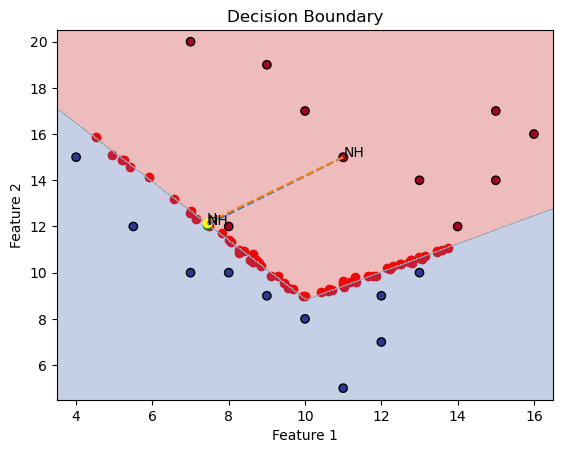

In [63]:
new_nn = nn_model()
df[['x1', 'x2']] = df[['x1', 'x2']].astype('float64')
df['y'] = df['y'].astype('int64')
new_nn, optimal_datapt = optimal_point(df, new_nn, desired_class=1, original_class=0, threshold=10000, chosen_row=4, epsilon=0.01, plot=True)
target_class=1
plot_decision_boundary(new_nn, X_train.to_numpy(), y_train)
cf = Counterfactual(new_nn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter,
                    feature_range=feature_range)
X_point = X_train.iloc[4, :].to_numpy().reshape(1, -1)
explainer = cf.explain(X_point)
cf_point = explainer.data['cf']['X'] 
points = [(X_point, cf_point)]
plot_func(points)
print("Optimal point distance:", euclidean_distance(X_point, optimal_datapt))
print("cf point distance:", euclidean_distance(X_point, cf_point))
plt.show()

Class counts:
 y
0    10
1    10
Name: count, dtype: int64
Fitting model...
Train on 5 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/1000
5/5 [==============================] - 0s 763us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6924 - acc: 0.5000
Epoch 2/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6784 - acc: 0.5000
Epoch 3/1000
5/5 [==============================] - 0s 518us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6791 - acc: 0.5000
Epoch 4/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6733 - acc: 0.5000
Epoch 5/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6727 - acc: 0.5000
Epoch 6/1000
5/5 [==============================] - 0s 766us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6704 - acc: 0.5000
Epoch 7/1000
5/5 [==============================] - 0s 501us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6684 - acc: 0.5000
Epoch 8/1000
5/5 [==============================] - 0s 520us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6669 - acc:

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(90, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.05087345 1.0503798 ]]
[[-1.203125 -2.765625]]
Optimal point distance: 3.1681711979318905
cf point distance: 3.522112


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\3996785700.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x, y = point[0], point[1]


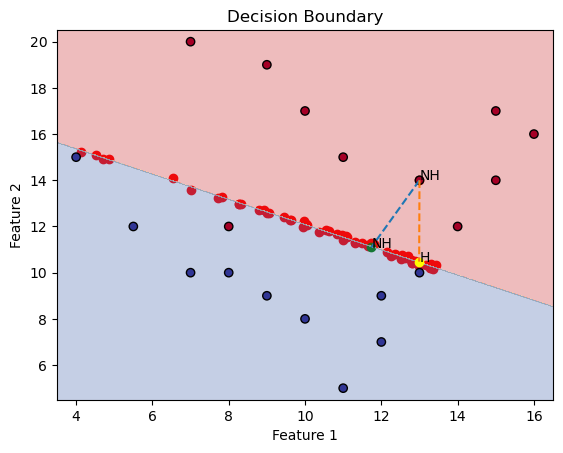

In [71]:
nn = nn_model()

chosen_row=5
nn, optimal_datapt = optimal_point(df, nn, desired_class=1, original_class=0, threshold=10000, chosen_row=chosen_row, epsilon=0.05, plot=True)
target_class=1
plot_decision_boundary(nn, X_train.to_numpy(), y_train)
cf = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter)
X_point = X_train.iloc[chosen_row,:]
explainer = cf.explain(np.reshape(X_point, (1,-1)))
cf_point = explainer.data['cf']['X'] 
points = [(X_point, cf_point)]
plot_func(points)
print("Optimal point distance:", euclidean_distance(X_point, optimal_datapt))
print("cf point distance:", euclidean_distance(X_point, cf_point))
plt.show()

In [72]:
print(nn.predict(cf_point))

[[0.5093299  0.49067008]]


In [73]:
print(nn.predict(np.reshape(optimal_datapt, (1,-1))))

[[0.48747975 0.51252025]]


In [74]:
nn=nn_model()
optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
inv_map = { 
    0: 1, 
    1: 0
}
df[['x1', 'x2']] = df[['x1', 'x2']].astype('float64')
for i in range(df.shape[0]):
    X_point = df.iloc[i,:-1]
    y_point = df.iloc[i,-1]
    y_label = int(y_point.item())
    target_label = inv_map[y_label]
    print(y_label) 
    print(target_label)
    if y_label == 0:
        nn, optimal_datapt = optimal_point(df, nn, desired_class=inv_map[y_label], original_class=y_label, threshold=50000, chosen_row=i, epsilon=0.05)

        target_class=target_label
        explainer2 = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                                target_class=target_class)
        #print(np.reshape(X_point, (1,-1)).shape)
        cf = explainer2.explain(np.reshape(X_point, (1,-1)))
        cf_point = cf.data['cf']['X'] 
        cf_pt_probs = nn.predict(np.reshape(cf_point, (1,-1)))
        opt_pt_probs = nn.predict(np.reshape(optimal_datapt, (1,-1)))
        optimal_probs.append(opt_pt_probs)
        wachter_probs.append(cf_pt_probs)
        optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
        wachter_dists.append(euclidean_distance(X_point, cf_point))
        # print(cf_point)
        # print(income_nn.predict(np.reshape(X_point, (1,-1))))
        # print("DISTANCE:", euclidean_distance(X_point, cf_point))

0
1
Class counts:
 y
0    10
1    10
Name: count, dtype: int64
Fitting model...
Train on 5 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/1000
5/5 [==============================] - 0s 641us/step - batch: 2.0000 - size: 1.0000 - loss: 0.7667 - acc: 0.5000
Epoch 2/1000
5/5 [==============================] - 0s 625us/step - batch: 2.0000 - size: 1.0000 - loss: 0.7438 - acc: 0.5200
Epoch 3/1000
5/5 [==============================] - 0s 501us/step - batch: 2.0000 - size: 1.0000 - loss: 0.7266 - acc: 0.5200
Epoch 4/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.7141 - acc: 0.5000
Epoch 5/1000
5/5 [==============================] - 0s 768us/step - batch: 2.0000 - size: 1.0000 - loss: 0.7051 - acc: 0.5000
Epoch 6/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6992 - acc: 0.5000
Epoch 7/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6956 - acc: 0.4600
Epoch 8/1000
5/5 [==============================] - 0s 523us/step - batch: 2.0000 - size: 1.0000 - loss: 0.6937 - acc:

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(90, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.05047014 1.05021004]]
[[-2.234375 -5.      ]]
0
1
Class counts:
 y
0    10
1    10
Name: count, dtype: int64
Fitting model...
Train on 5 samples
Epoch 1/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 2/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 3/1000
5/5 [==============================] - 0s 499us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 4/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 5/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 6/1000
5/5 [==============================] - 0s 500us/

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5/5 [==============================] - 0s 751us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 45/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 46/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 47/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 48/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 49/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 50/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.950

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 41/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 42/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 537us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 45/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 46/1000
5/5 [==============================] - 0s 779us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 47/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 48/1000
5/5 [==============================] - 0s 518us/step - batch: 2.0000 - size: 1.0000 - loss: 0.144

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 45/1000
5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 46/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 47/1000
5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 48/1000
5/5 [==============================] - 0s 785us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 49/1000
5/5 [==============================] - 0s 998us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Ep

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 44/1000
5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 45/1000
5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 46/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 47/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 48/1000
5/5 [==============================] - 0s 780us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 49/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 50/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 51/1000
5/5 [==============================] - 0s 627us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - 

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 38/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 39/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 40/1000
5/5 [==============================] - 0s 1000us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 41/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 42/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 787us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.95

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 36/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 37/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 38/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 39/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 40/1000
5/5 [==============================] - 0s 751us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 41/1000
5/5 [==============================] - 0s 773us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 42/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 901us/step - batch: 2.0000 - size: 1.0000 - loss: 0.144

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 37/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 38/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 39/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 40/1000
5/5 [==============================] - 0s 533us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 41/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 42/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.144

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 37/1000
5/5 [==============================] - 0s 774us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 38/1000
5/5 [==============================] - 0s 1000us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 39/1000
5/5 [==============================] - 0s 1000us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 40/1000
5/5 [==============================] - 0s 913us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 41/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 42/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 43/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 44/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13932\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 35/1000
5/5 [==============================] - 0s 781us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 36/1000
5/5 [==============================] - 0s 500us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 37/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 38/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 39/1000
5/5 [==============================] - 0s 1ms/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 40/1000
5/5 [==============================] - 0s 749us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Epoch 41/1000
5/5 [==============================] - 0s 750us/step - batch: 2.0000 - size: 1.0000 - loss: 0.1448 - acc: 0.9500
Ep

In [75]:
print(np.mean(optimal_dists), np.mean(wachter_dists))

4.3167593470051395 4.522210562357206


In [76]:
print(np.mean(optimal_probs,axis=0), np.mean(wachter_probs,axis=0))

[[0.4488957 0.5511043]] [[0.50675935 0.49324068]]


In [10]:
def convert_columns(df): 
    inv_col_map = {} 

    for col in df.columns: 
        any_string = df[col].apply(lambda x: isinstance(x, str)).any()

        if not any_string: 
            df[col] = df[col].astype('float64')
        else: 
            inv_col_map[col] = {}
            unique_vals = np.unique(df[col])

            for i, val in enumerate(unique_vals): 
                inv_col_map[col][i] = val 
                df.loc[df[col] == val, col] = i

            df[col] = df[col].astype('int32')

    return inv_col_map

In [25]:
tf.keras.backend.clear_session()  # For TensorFlow 2.x

In [26]:
dataset = helpers.load_adult_income_dataset()

c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\utils\helpers.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data = adult_data.replace({'income': {'<=50K': 0, '>50K': 1}})


In [27]:
target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)

In [42]:
print(dataset.shape)

(26048, 9)


In [32]:
def nn_model():
    x_in = Input(shape=(8,))

    x = Flatten()(x_in)
    x = Dense(8, activation='relu')(x)
    x = Dense(10, activation='relu')(x) 
    probs = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=probs)
    nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [33]:
dataset.head(n=10)

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0
5,40,Private,Some-college,Divorced,Blue-Collar,White,Male,50,0
6,24,Private,Bachelors,Single,White-Collar,White,Male,40,0
7,54,Private,Assoc,Married,Service,Other,Male,38,1
8,27,Private,Some-college,Single,Service,White,Male,40,0
9,57,Private,Some-college,Married,Professional,White,Male,40,1


In [34]:
dataset.iloc[25954,:]

age                          28
workclass         Other/Unknown
education                 Assoc
marital_status        Separated
occupation        Other/Unknown
race                      White
gender                   Female
hours_per_week               40
income                        0
Name: 25954, dtype: object

In [35]:
dataset.iloc[2,:]

age                         32
workclass              Private
education         Some-college
marital_status         Married
occupation        White-Collar
race                     White
gender                    Male
hours_per_week              50
income                       0
Name: 2, dtype: object

In [36]:
shape = (1,) + datasetX.shape[1:]
print(shape)
target_proba = 0.5
tol = 0.0001 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1

(1, 8)


In [35]:
income_nn=nn_model()
income_nn, optimal_datapt = optimal_point(dataset, income_nn, desired_class=1, original_class=0, threshold=10000, chosen_row=25954, point_epsilon=1e-3, epsilon=1e-3)
X_point = dataset.iloc[25954,:-1]
target_class=1
explainer2 = Counterfactual(income_nn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class)
print(np.reshape(X_point, (1,-1)).shape)
cf = explainer2.explain(np.reshape(X_point, (1,-1)))
cf_point = cf.data['cf']['X'] 
print(cf_point)
print(income_nn.predict(np.reshape(X_point, (1,-1))))
print("DISTANCE:", euclidean_distance(X_point, cf_point))

Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Train on 39640 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_39088\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/200
39640/39640 [==============================] - 0s 4us/sample - loss: 2.9619 - acc: 0.5032
Epoch 2/200
39640/39640 [==============================] - 0s 1us/sample - loss: 1.2190 - acc: 0.5143
Epoch 3/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.7032 - acc: 0.5798
Epoch 4/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6558 - acc: 0.6316
Epoch 5/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6540 - acc: 0.6347
Epoch 6/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6525 - acc: 0.6375
Epoch 7/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6510 - acc: 0.6392
Epoch 8/200
 1000/39640 [..............................] - ETA: 0s - loss: 0.6462 - acc: 0.6470

KeyboardInterrupt: 

Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Train on 39640 samples
   32/39640 [..............................] - ETA: 37s - loss: 6.8273 - acc: 0.5000

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_28144\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


39640/39640 [==============================] - 0s 12us/sample - loss: 0.8084 - acc: 0.6226
Model training complete.
boundary points started generation...


c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(50000, 8)
(49835, 8)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.99931139 0.99850693 0.99767158 0.99850693 0.99850693 0.
  0.99767158 0.        ]]
[[0.59179688 0.4005127  0.29974365 0.4005127  0.4005127  0.
  0.29974365 0.        ]]
EUCLIDEAN DISTANCE FOR NEAREST CF 1.0041879160230396
(1, 8)
[[31.99953     2.0002198   6.9992642   0.9943504   4.997899    1.0212994
   0.11540653 49.999535  ]]
[[0.36358514 0.6364149 ]]
DISTANCE: 0.8848709691168858


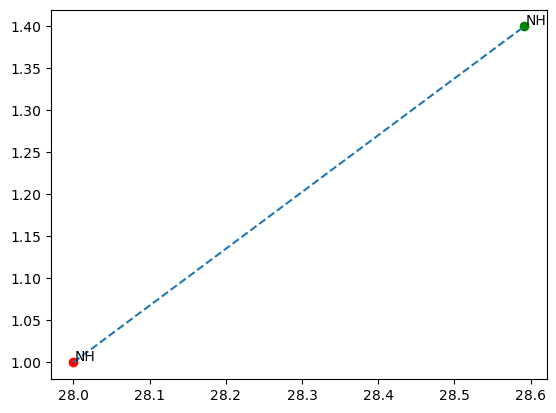

In [ ]:
nn=nn_model()
optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
for i in range(50):
    X_point = dataset.iloc[i,:-1]
    y_point = dataset.iloc[i,-1]
    if y_point.item() == 0:
        nn, optimal_datapt = optimal_point(dataset, nn, desired_class=1, original_class=0, threshold=25000, chosen_row=i, point_epsilon=1e-4, epsilon=1e-3)

        target_class=1
        explainer2 = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                            target_class=target_class)
        #print(np.reshape(X_point, (1,-1)).shape)
        cf = explainer2.explain(np.reshape(X_point, (1,-1)))
        cf_point = cf.data['cf']['X'] 
        cf_pt_probs = nn.predict(cf_point)
        opt_pt_probs = nn.predict(optimal_datapt)
        optimal_probs.append(opt_pt_probs)
        wachter_probs.append(cf_pt_probs)
        optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
        wachter_dists.append(euclidean_distance(X_point, cf_point))
        # print(cf_point)
        # print(income_nn.predict(np.reshape(X_point, (1,-1))))
        # print("DISTANCE:", euclidean_distance(X_point, cf_point))

Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Train on 39640 samples
   32/39640 [..............................] - ETA: 32s - loss: 20.3008 - acc: 0.4375

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_28144\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


39640/39640 [==============================] - 0s 12us/sample - loss: 1.1345 - acc: 0.6453
Model training complete.
boundary points started generation...


c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(50000, 8)
(49828, 8)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00281488 0.         0.         1.0025203  0.         0.
  1.01289627 1.00217704]]
[[-0.55255127  0.          0.         -0.65942383  0.          0.
  -0.08514404 -0.85144043]]
EUCLIDEAN DISTANCE FOR NEAREST CF 1.2163950796579504
(1, 8)
[[31.993063    1.9982318   6.9935513   0.98225963  4.998277    1.0076674
   1.3239831  50.0078    ]]
[[0.5802779  0.41972202]]
DISTANCE: 0.3248002488569878


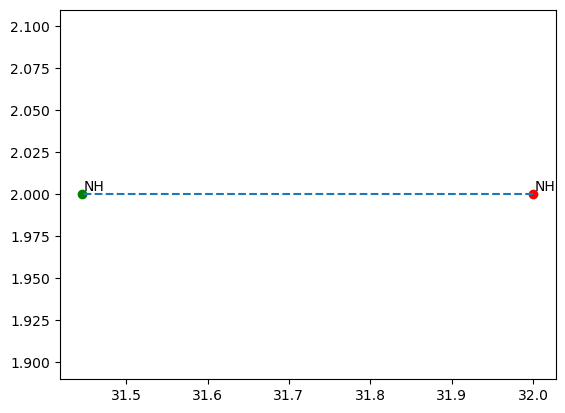

In [46]:
income_nn=nn_model()
income_nn, optimal_datapt = optimal_point(dataset, income_nn, desired_class=1, original_class=0, threshold=50000, chosen_row=2, point_epsilon=1e-3, epsilon=1e-3)
X_point = dataset.iloc[2,:-1]
target_class=1
explainer2 = Counterfactual(income_nn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class)
print(np.reshape(X_point, (1,-1)).shape)
cf = explainer2.explain(np.reshape(X_point, (1,-1)))
cf_point = cf.data['cf']['X'] 
print(cf_point)
print(income_nn.predict(np.reshape(X_point, (1,-1))))
print("DISTANCE:", euclidean_distance(X_point, cf_point))

In [47]:
print(income_nn.predict(cf_point))

[[0.50962937 0.49037063]]


In [48]:
print(income_nn.predict(np.reshape(optimal_datapt, (1,-1))))

[[0.49997294 0.50002706]]


In [ ]:
income_nn=nn_model()
optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
X_train = dataset.iloc[:,:-1]
convert_columns(X_train)
for i in range(50):
    X_point = X_train.iloc[i,:]
    y_point = dataset.iloc[i,-1]
    if y_point.item() == 0:
        try:
            income_nn, optimal_datapt = optimal_point(dataset, income_nn, desired_class=1, original_class=0, threshold=30000, chosen_row=i, point_epsilon=1e-4, epsilon=1e-3)

            target_class=1
            explainer2 = Counterfactual(income_nn, shape=shape, target_proba=target_proba, tol=tol,
                                target_class=target_class)
            #print(np.reshape(X_point, (1,-1)).shape)
            cf = explainer2.explain(np.reshape(X_point, (1,-1)))
            cf_point = cf.data['cf']['X'] 
            cf_pt_probs = income_nn.predict(cf_point)
            opt_pt_probs = income_nn.predict(optimal_datapt)
            optimal_probs.append(opt_pt_probs)
            wachter_probs.append(cf_pt_probs)
            optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
            wachter_dists.append(euclidean_distance(X_point, cf_point))
        # print(cf_point)
        # print(income_nn.predict(np.reshape(X_point, (1,-1))))
        # print("DISTANCE:", euclidean_distance(X_point, cf_point))
        except TypeError: 
            continue

Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Train on 39640 samples
Epoch 1/200


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_24992\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


39640/39640 [==============================] - 0s 3us/sample - loss: 5.2444 - acc: 0.4918
Epoch 2/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.8096 - acc: 0.5339
Epoch 3/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6457 - acc: 0.6597
Epoch 4/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6335 - acc: 0.6711
Epoch 5/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6247 - acc: 0.6811
Epoch 6/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6168 - acc: 0.6859
Epoch 7/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6097 - acc: 0.6903
Epoch 8/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.6031 - acc: 0.6951
Epoch 9/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.5977 - acc: 0.6975
Epoch 10/200
39640/39640 [==============================] - 0s 1us/sample - loss: 0.5927 - acc

KeyboardInterrupt: 

In [24]:
print(np.mean(optimal_dists), np.mean(wachter_dists))

2.347184081366327 1.2875562298294163


In [25]:
print(np.mean(opt_pt_probs,axis=0), np.mean(cf_pt_probs,axis=0))

[0.5004027 0.4995973] [0.50911397 0.490886  ]


In [ ]:
print(dataset['target'])

In [57]:
optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
convert_columns(dataset)
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 25)

for i in random_integers:
    real_idx = sub_dataset.index[i]
    X_point = dataset.iloc[real_idx,:-1]
    idx = dataset.index[real_idx]
    print(idx)
    nn=nn_model()

    nn, optimal_datapt = optimal_point(dataset, nn, desired_class=1, original_class=0, threshold=10000, chosen_row=idx, point_epsilon=1e-3, epsilon=1e-2)

    target_class=1
    explainer2 = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                            target_class=target_class)
    #print(np.reshape(X_point, (1,-1)).shape)
    cf = explainer2.explain(np.reshape(X_point, (1,-1)))
    cf_point = cf.data['cf']['X'] 
    cf_pt_probs = nn.predict(cf_point)
    opt_pt_probs = nn.predict(optimal_datapt)
    optimal_probs.append(opt_pt_probs)
    wachter_probs.append(cf_pt_probs)
    optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
    wachter_dists.append(euclidean_distance(X_point, cf_point))
    # print(cf_point)
    # print(income_nn.predict(np.reshape(X_point, (1,-1))))
    # print("DISTANCE:", euclidean_distance(X_point, cf_point))

4104
Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Train on 10000 samples
Epoch 1/100
   32/10000 [..............................] - ETA: 9s - loss: 2.6611 - acc: 0.4688

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


10000/10000 [==============================] - 0s 15us/sample - loss: 0.7310 - acc: 0.6106
Epoch 2/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5867 - acc: 0.6808
Epoch 3/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5687 - acc: 0.6955
Epoch 4/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5594 - acc: 0.7029
Epoch 5/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5536 - acc: 0.7086
Epoch 6/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5507 - acc: 0.7115
Epoch 7/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5480 - acc: 0.7131
Epoch 8/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5440 - acc: 0.7142
Epoch 9/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5412 - acc: 0.7159
Epoch 10/100
10000/10000 [==============================] - 0s 12us/sample - loss: 0.

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


KeyboardInterrupt: 

In [ ]:
print(np.mean(optimal_dists), np.mean(wachter_dists))

2.80614062004767 1.6352341867911546


In [ ]:
print(np.mean(opt_pt_probs,axis=0), np.mean(cf_pt_probs,axis=0))

[0.5016694 0.4983306] [0.49990672 0.5000933 ]


In [ ]:
heart_disease = pd.read_csv(
'../heart.csv'
)

In [20]:
heart_disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59.0,1.0,1.0,140.0,221.0,0.0,1.0,164.0,1.0,0.0,2.0,0.0,2.0,1.0
1021,60.0,1.0,0.0,125.0,258.0,0.0,0.0,141.0,1.0,2.8,1.0,1.0,3.0,0.0
1022,47.0,1.0,0.0,110.0,275.0,0.0,0.0,118.0,1.0,1.0,1.0,1.0,2.0,0.0
1023,50.0,0.0,0.0,110.0,254.0,0.0,0.0,159.0,0.0,0.0,2.0,0.0,2.0,1.0


In [62]:
shape = (1,heart_disease.shape[1]-1)
target_proba = 0.5
tol = 0.0001 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (heart_disease.min(),heart_disease.max())

In [4]:
shape

(1, 13)

In [ ]:
def nn_model():
    x_in = Input(shape=(13,))

    x = Flatten()(x_in)
    x = Dense(8, activation='relu')(x)
    x = Dense(10, activation='relu')(x) 
    probs = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=probs)
    nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [65]:
tf.keras.backend.clear_session()  # For TensorFlow 2.x

In [66]:
shape

(1, 13)

In [71]:

optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)

for i in random_integers:
        try:
            real_idx = sub_dataset.index[i]
            X_point = heart_disease.iloc[real_idx,:-1]
            nn=nn_model()

            nn, optimal_datapt = optimal_point(heart_disease, nn, desired_class=1, original_class=0, threshold=10000, chosen_row=real_idx, point_epsilon=1e-3, epsilon=1e-2)

            target_class=1
            explainer2 = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                                    target_class=target_class)
            #print(np.reshape(X_point, (1,-1)).shape)
            cf = explainer2.explain(np.reshape(X_point, (1,-1)))
            cf_point = cf.data['cf']['X'] 
            cf_pt_probs = nn.predict(cf_point)
            opt_pt_probs = nn.predict(optimal_datapt)
            optimal_probs.append(opt_pt_probs)
            wachter_probs.append(cf_pt_probs)
            optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
            wachter_dists.append(euclidean_distance(X_point, cf_point))
        except TypeError: 
              continue

    # print(cf_point)
    # print(income_nn.predict(np.reshape(X_point, (1,-1))))
    # print("DISTANCE:", euclidean_distance(X_point, cf_point))

Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples
Epoch 1/100


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


1052/1052 [==============================] - 0s 49us/sample - loss: 76.9421 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 13us/sample - loss: 16.8254 - acc: 0.5105
Epoch 3/100
1052/1052 [==============================] - 0s 13us/sample - loss: 2.4906 - acc: 0.5903
Epoch 4/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.5532 - acc: 0.5646
Epoch 5/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.2112 - acc: 0.5684
Epoch 6/100
1052/1052 [==============================] - 0s 12us/sample - loss: 1.0336 - acc: 0.5779
Epoch 7/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.8706 - acc: 0.6198
Epoch 8/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.6991 - acc: 0.6816
Epoch 9/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.5893 - acc: 0.7129
Epoch 10/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.5495 - acc: 0.7386

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00536525 0.         1.00077284 1.0102875  1.00963666 1.01341009
  1.01101101 1.00940872 1.01143912 1.00873083 1.01143912 1.00661279
  1.01101101]]
[[ 0.21691895  0.          0.10845947 -3.51409912  2.77874756 -0.29718018
  -1.          1.70715332 -0.70281982  0.7947937  -0.70281982  0.29718018
  -1.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples
Epoch 1/100


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


1052/1052 [==============================] - 0s 48us/sample - loss: 24.8287 - acc: 0.4990
Epoch 2/100
1052/1052 [==============================] - 0s 13us/sample - loss: 2.9452 - acc: 0.5399
Epoch 3/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.9095 - acc: 0.5865
Epoch 4/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.5456 - acc: 0.5875
Epoch 5/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.2155 - acc: 0.6036
Epoch 6/100
1052/1052 [==============================] - 0s 12us/sample - loss: 0.9520 - acc: 0.6169
Epoch 7/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.7990 - acc: 0.6302
Epoch 8/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.7017 - acc: 0.6587
Epoch 9/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.6935 - acc: 0.6768
Epoch 10/100
1052/1052 [==============================] - 0s 12us/sample - loss: 0.6450 - acc: 0.6825


c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00957751 1.00846884 1.01076733 1.00990021 1.02719049 1.00704997
  1.01101101 1.0101748  0.         1.00631516 0.         1.00939143
  1.00846884]]
[[ 2.3895874   0.65863037 -1.31726074 10.12054443 -0.05975342  0.34136963
  -1.         -5.7791748   0.          0.2730957   0.          1.65863037
   0.65863037]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples
Epoch 1/100


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


1052/1052 [==============================] - 0s 57us/sample - loss: 126.9342 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 15us/sample - loss: 75.0457 - acc: 0.5000
Epoch 3/100
1052/1052 [==============================] - 0s 14us/sample - loss: 35.6413 - acc: 0.5000
Epoch 4/100
1052/1052 [==============================] - 0s 13us/sample - loss: 4.3952 - acc: 0.5713
Epoch 5/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.5256 - acc: 0.5637
Epoch 6/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.2542 - acc: 0.5932
Epoch 7/100
1052/1052 [==============================] - 0s 13us/sample - loss: 1.0834 - acc: 0.6207
Epoch 8/100
1052/1052 [==============================] - 0s 13us/sample - loss: 0.9934 - acc: 0.6378
Epoch 9/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.9529 - acc: 0.6407
Epoch 10/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.9057 - acc: 0.66

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00948739 1.00899101 1.01083383 1.01087635 1.01076006 0.
  1.00899101 1.00925962 0.         1.00911194 1.00899101 1.00916755
  1.00833646]]
[[ 1.96929932  1.         -1.21228027 -1.15350342 -1.32983398  0.
   1.          1.36315918  0.          1.13631592  1.          1.21228027
   0.60614014]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 58us/sample - loss: 26.7375 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 14us/sample - loss: 6.1663 - acc: 0.5247
Epoch 3/100
1052/1052 [==============================] - 0s 14us/sample - loss: 3.7694 - acc: 0.5684
Epoch 4/100
1052/1052 [==============================] - 0s 13us/sample - loss: 2.5219 - acc: 0.6122
Epoch 5/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.8738 - acc: 0.6426
Epoch 6/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.6646 - acc: 0.6549
Epoch 7/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.5899 - acc: 0.6644
Epoch 8/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.4786 - acc: 0.6787
Epoch 9/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.4066 - acc: 0.6825
Epoch 10/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.3485 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0106121  1.00816815 1.01091843 1.0096331  1.01036717 1.01183852
  0.         1.00938864 1.00816815 1.00885431 0.         0.
  1.00816815]]
[[-1.65106201  0.550354   -1.10070801  2.75177002 -2.75177002 -0.550354
   0.          1.65106201  0.550354    0.88056641  0.          0.
   0.550354  ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 74us/sample - loss: 9.2550 - acc: 0.5504
Epoch 2/100
1052/1052 [==============================] - 0s 18us/sample - loss: 2.3762 - acc: 0.6483
Epoch 3/100
1052/1052 [==============================] - 0s 19us/sample - loss: 2.1802 - acc: 0.6559
Epoch 4/100
1052/1052 [==============================] - 0s 19us/sample - loss: 2.1161 - acc: 0.6511
Epoch 5/100
1052/1052 [==============================] - 0s 18us/sample - loss: 1.8702 - acc: 0.6663
Epoch 6/100
1052/1052 [==============================] - 0s 18us/sample - loss: 1.7280 - acc: 0.6768
Epoch 7/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.5580 - acc: 0.6854
Epoch 8/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.4060 - acc: 0.6835
Epoch 9/100
1052/1052 [==============================] - 0s 19us/sample - loss: 1.2437 - acc: 0.6892
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.1782 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01046361 1.0078219  1.01109258 1.00983496 1.00981416 0.
  1.00934343 1.00982054 1.0078219  1.00739424 0.         1.0078219
  1.0078219 ]]
[[-2.17956543  0.46270752 -0.92541504  6.11877441  5.43371582  0.
   1.53729248  5.6270752   0.46270752  0.38660278  0.          0.46270752
   0.46270752]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 86us/sample - loss: 5.1534 - acc: 0.5618
Epoch 2/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.8098 - acc: 0.6226
Epoch 3/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.5452 - acc: 0.6388
Epoch 4/100
1052/1052 [==============================] - 0s 19us/sample - loss: 1.4677 - acc: 0.6644
Epoch 5/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.3639 - acc: 0.6663
Epoch 6/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.2750 - acc: 0.6730
Epoch 7/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.2037 - acc: 0.6740
Epoch 8/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.1434 - acc: 0.6825
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.1223 - acc: 0.6882
Epoch 10/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.0175 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01139519 0.         1.01183914 0.99968586 1.01058174 1.01101101
  1.00920852 1.01287009 0.         1.00957406 1.01183914 1.00877762
  1.01368498]]
[[-0.72491455  0.         -0.5501709   0.09692383 -1.73718262 -1.
   1.27508545 -0.35290527  0.          2.37023926 -0.5501709   0.82525635
  -0.27508545]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 71us/sample - loss: 39.6895 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 17us/sample - loss: 6.7260 - acc: 0.5323
Epoch 3/100
1052/1052 [==============================] - 0s 19us/sample - loss: 2.6001 - acc: 0.6065
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 2.1327 - acc: 0.6122
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 1.8399 - acc: 0.6217
Epoch 6/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.5992 - acc: 0.6179
Epoch 7/100
1052/1052 [==============================] - 0s 20us/sample - loss: 1.3894 - acc: 0.6217
Epoch 8/100
1052/1052 [==============================] - 0s 18us/sample - loss: 1.1923 - acc: 0.6217
Epoch 9/100
1052/1052 [==============================] - 0s 18us/sample - loss: 1.0273 - acc: 0.6331
Epoch 10/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.8742 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0105108  1.00800566 1.00796193 1.01104511 1.00961621 1.00800566
  1.00796193 1.01065711 1.00800566 1.0093558  1.01067135 0.
  1.00800566]]
[[-1.97827148  0.50543213  0.49456787 -0.96740723  2.63061523  0.50543213
   0.49456787 -1.5380249   0.50543213  1.5668396  -1.50543213  0.
   0.50543213]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 95us/sample - loss: 10.5962 - acc: 0.4981
Epoch 2/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.1246 - acc: 0.5048
Epoch 3/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.6818 - acc: 0.6008
Epoch 4/100
1052/1052 [==============================] - 0s 16us/sample - loss: 0.6520 - acc: 0.6264
Epoch 5/100
1052/1052 [==============================] - 0s 16us/sample - loss: 0.6442 - acc: 0.6293
Epoch 6/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.6390 - acc: 0.6407
Epoch 7/100
1052/1052 [==============================] - 0s 18us/sample - loss: 0.6354 - acc: 0.6445
Epoch 8/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.6177 - acc: 0.6721
Epoch 9/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.6157 - acc: 0.6549
Epoch 10/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.6088 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00894924 1.01687027 1.01050525 0.         1.01036297 0.
  1.00881593 1.01021659 0.         1.00810804 1.01342349 1.00659956
  0.        ]]
[[ 0.96020508 -0.14801025 -2.          0.         -2.78356934  0.
   0.85198975 -4.66418457  0.          0.53283691 -0.29602051  0.29602051
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 72us/sample - loss: 4.0459 - acc: 0.6112
Epoch 2/100
1052/1052 [==============================] - 0s 14us/sample - loss: 2.4880 - acc: 0.6331
Epoch 3/100
1052/1052 [==============================] - 0s 14us/sample - loss: 2.1526 - acc: 0.6312
Epoch 4/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.9607 - acc: 0.6435
Epoch 5/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.8074 - acc: 0.6606
Epoch 6/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.6477 - acc: 0.6692
Epoch 7/100
1052/1052 [==============================] - 0s 16us/sample - loss: 1.5072 - acc: 0.6778
Epoch 8/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.4000 - acc: 0.6730
Epoch 9/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.2877 - acc: 0.6768
Epoch 10/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.1774 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00964853 0.         1.01101101 1.01028511 1.00958105 0.
  1.01101101 1.01042874 1.00516906 1.00848535 1.0148776  1.00757874
  1.01101101]]
[[ 2.87261963  0.         -1.         -3.54351807  2.40979004  0.
  -1.         -2.35675049  0.20806885  0.66582031 -0.20806885  0.4161377
  -1.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 73us/sample - loss: 2.8770 - acc: 0.3973
Epoch 2/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.8754 - acc: 0.4240
Epoch 3/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.3813 - acc: 0.4173
Epoch 4/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.0924 - acc: 0.4734
Epoch 5/100
1052/1052 [==============================] - 0s 14us/sample - loss: 1.0073 - acc: 0.5133
Epoch 6/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.8595 - acc: 0.5380
Epoch 7/100
1052/1052 [==============================] - 0s 19us/sample - loss: 0.7855 - acc: 0.5856
Epoch 8/100
1052/1052 [==============================] - 0s 17us/sample - loss: 0.7222 - acc: 0.5951
Epoch 9/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.6697 - acc: 0.6464
Epoch 10/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.6321 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00970102 0.         1.00949525 1.00989901 1.01028735 1.00731165
  0.         1.01072621 0.         1.00934896 1.01073524 1.00946188
  0.        ]]
[[ 3.37713623  0.          2.         10.         -3.51586914  0.37469482
   0.         -1.39178467  0.          1.55036621 -1.37469482  1.87591553
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 77us/sample - loss: 56.6399 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 18us/sample - loss: 17.2794 - acc: 0.5029
Epoch 3/100
1052/1052 [==============================] - 0s 17us/sample - loss: 2.3874 - acc: 0.5418
Epoch 4/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.7862 - acc: 0.5618
Epoch 5/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.6279 - acc: 0.5637
Epoch 6/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.5072 - acc: 0.5504
Epoch 7/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.3741 - acc: 0.5637
Epoch 8/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.2764 - acc: 0.5570
Epoch 9/100
1052/1052 [==============================] - 0s 17us/sample - loss: 1.1584 - acc: 0.5675
Epoch 10/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.1087 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01079842 1.00651726 1.01071077 1.01011968 1.0114871  1.00651726
  0.         1.0097461  1.00651726 1.00804491 1.01101101 0.
  1.00651726]]
[[-1.26599121  0.28900146 -1.42199707 -8.43994141 -0.68017578  0.28900146
   0.          3.97698975  0.28900146  0.51560059 -1.          0.
   0.28900146]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 82us/sample - loss: 18.4226 - acc: 0.5048
Epoch 2/100
1052/1052 [==============================] - 0s 15us/sample - loss: 2.2103 - acc: 0.5846
Epoch 3/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.5521 - acc: 0.5837
Epoch 4/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.2243 - acc: 0.5675
Epoch 5/100
1052/1052 [==============================] - 0s 15us/sample - loss: 1.0203 - acc: 0.5561
Epoch 6/100
1052/1052 [==============================] - 0s 16us/sample - loss: 0.8901 - acc: 0.5865
Epoch 7/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.8186 - acc: 0.5884
Epoch 8/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.7814 - acc: 0.6169
Epoch 9/100
1052/1052 [==============================] - 0s 16us/sample - loss: 0.7399 - acc: 0.6397
Epoch 10/100
1052/1052 [==============================] - 0s 15us/sample - loss: 0.7264 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00907762 0.         1.01149963 1.00928898 1.00921277 0.
  1.00690659 1.01056393 1.00850481 1.01161729 0.         0.
  1.00850481]]
[[ 1.09399414  0.         -0.67449951  1.41949463  1.28198242  0.
   0.32550049 -1.79199219  0.67449951 -0.62550049  0.          0.
   0.67449951]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 125us/sample - loss: 2.0459 - acc: 0.5741
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.9451 - acc: 0.5760
Epoch 3/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7215 - acc: 0.5741
Epoch 4/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6702 - acc: 0.5789
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6642 - acc: 0.5751
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6636 - acc: 0.5713
Epoch 7/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6616 - acc: 0.5694
Epoch 8/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6556 - acc: 0.5760
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6798 - acc: 0.5703
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6688 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01214111 1.0086988  1.01130456 1.00964321 1.01055734 0.
  0.         1.00824209 1.0086988  1.01091902 0.         1.00899101
  1.0086988 ]]
[[-0.47271729  0.77520752 -0.77520752  2.82977295 -1.81317139  0.
   0.          0.57354736  0.77520752 -1.1         0.          1.
   0.77520752]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 114us/sample - loss: 15.8113 - acc: 0.4591
Epoch 2/100
1052/1052 [==============================] - 0s 21us/sample - loss: 4.3881 - acc: 0.4087
Epoch 3/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.1053 - acc: 0.5589
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6161 - acc: 0.7110
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.5892 - acc: 0.7072
Epoch 6/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.5737 - acc: 0.7329
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.5669 - acc: 0.7253
Epoch 8/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.5622 - acc: 0.7262
Epoch 9/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.5465 - acc: 0.7338
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.5463 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00811965 0.         1.00960221 1.01032805 1.00917703 1.00899101
  0.         1.01030576 1.00348352 1.01058145 1.01087598 1.00880757
  1.00912553]]
[[ 0.53613281  0.          2.5380249  -3.07983398  1.22625732  1.
   0.         -3.30419922  0.1539917  -1.7380249  -1.1539917   0.8460083
   1.1539917 ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 129us/sample - loss: 4.4316 - acc: 0.5048
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.5805 - acc: 0.5770
Epoch 3/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.9739 - acc: 0.5998
Epoch 4/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7897 - acc: 0.6274
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7515 - acc: 0.6255
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7160 - acc: 0.6559
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7144 - acc: 0.6188
Epoch 8/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7009 - acc: 0.6283
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6879 - acc: 0.6264
Epoch 10/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.6722 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00947738 0.         0.         1.00964064 1.00952091 0.
  1.01578471 1.01047954 1.0042808  1.00726847 1.01578471 1.00808638
  1.0042808 ]]
[[ 1.93157959  0.          0.          2.80957031  2.10717773  0.
  -0.17559814 -2.10717773  0.17559814  0.3687561  -0.17559814  0.52679443
   0.17559814]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 124us/sample - loss: 32.4644 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 5.1185 - acc: 0.5722
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.6839 - acc: 0.6245
Epoch 4/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1704 - acc: 0.6198
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.0392 - acc: 0.6359
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.9692 - acc: 0.6340
Epoch 7/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.8936 - acc: 0.6188
Epoch 8/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.8268 - acc: 0.6350
Epoch 9/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7733 - acc: 0.6397
Epoch 10/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7500 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01029359 1.0072445  1.01042714 1.01027638 1.00958342 0.
  1.01277062 1.00958147 0.         1.0110958  1.01277062 1.0072445
  0.        ]]
[[-3.44122314  0.36553955 -2.36553955 -3.65539551  2.42352295  0.
  -0.36553955  2.41223145  0.         -0.92270508 -0.36553955  0.36553955
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 133us/sample - loss: 2.1447 - acc: 0.5865
Epoch 2/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.7830 - acc: 0.6587
Epoch 3/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6618 - acc: 0.6673
Epoch 4/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6199 - acc: 0.6625
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.5963 - acc: 0.6759
Epoch 6/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.5869 - acc: 0.6797
Epoch 7/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5726 - acc: 0.6939
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.5662 - acc: 0.6911
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5686 - acc: 0.6844
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.5615 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01032539 0.         1.01312128 1.00922268 1.00970016 0.
  1.01626192 1.01049002 1.01120711 1.00967599 1.0105499  1.00381478
  0.        ]]
[[-3.10498047  0.         -0.32458496  1.29833984  3.36743164  0.
  -0.16229248 -2.06213379 -0.83770752  3.11622925 -1.83770752  0.16229248
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 135us/sample - loss: 11.8260 - acc: 0.4990
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.2015 - acc: 0.5228
Epoch 3/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6752 - acc: 0.5989
Epoch 4/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6438 - acc: 0.6274
Epoch 5/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6294 - acc: 0.6435
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6182 - acc: 0.6473
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6311 - acc: 0.6217
Epoch 8/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6241 - acc: 0.6188
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6137 - acc: 0.6331
Epoch 10/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.5992 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0097226  1.00899101 1.01101101 1.01046195 1.01041658 0.
  1.00871776 1.00857252 0.         1.01168614 0.         1.00528737
  1.00871776]]
[[ 3.63995361  1.         -1.         -2.18737793 -2.42547607  0.
   0.78668213  0.70654297  0.         -0.6         0.          0.21331787
   0.78668213]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 139us/sample - loss: 32.4078 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 4.0102 - acc: 0.5751
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 2.0199 - acc: 0.6141
Epoch 4/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.7263 - acc: 0.6350
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.4502 - acc: 0.6283
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.1981 - acc: 0.6378
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.0168 - acc: 0.6426
Epoch 8/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.8663 - acc: 0.6483
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7679 - acc: 0.6502
Epoch 10/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7191 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00889159 1.00668206 1.01166719 1.00977812 1.01001376 0.
  0.         1.01006528 0.         1.00585598 0.         1.00889159
  1.01333988]]
[[  0.91021729   0.30340576  -0.60681152   4.55108643 -73.42419434
    0.           0.         -15.47369385   0.           0.24272461
    0.           0.91021729  -0.30340576]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 141us/sample - loss: 16.5941 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 24us/sample - loss: 9.2513 - acc: 0.5000
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 4.9690 - acc: 0.4990
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 2.0617 - acc: 0.4800
Epoch 5/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.8310 - acc: 0.4487
Epoch 6/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6909 - acc: 0.5494
Epoch 7/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6347 - acc: 0.6549
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6177 - acc: 0.6549
Epoch 9/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.6115 - acc: 0.6616
Epoch 10/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6075 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00934875 0.98667294 0.         0.99820021 1.00976006 0.
  0.98667294 1.00761778 0.         1.01507538 0.98667294 0.98667294
  0.98667294]]
[[ 1.54986572  0.04229736  0.          0.08459473  4.20837402  0.
   0.04229736  0.42297363  0.         -0.2         0.04229736  0.04229736
   0.04229736]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 152us/sample - loss: 2.2609 - acc: 0.5010
Epoch 2/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.0808 - acc: 0.5960
Epoch 3/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.9178 - acc: 0.5884
Epoch 4/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.8073 - acc: 0.6226
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.7382 - acc: 0.6264
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7104 - acc: 0.6359
Epoch 7/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6751 - acc: 0.6445
Epoch 8/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6620 - acc: 0.6435
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6345 - acc: 0.6578
Epoch 10/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6415 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00949233 1.00815054 1.0106541  1.01111137 1.00925626 0.
  1.01185626 1.01296524 1.00815054 1.00261153 1.00778458 1.00907442
  1.00815054]]
[[ 1.98846436  0.54510498 -1.54510498 -0.90979004  1.35699463  0.
  -0.54510498 -0.34161377  0.54510498  0.13569946  0.45489502  1.09020996
   0.54510498]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 113us/sample - loss: 0.9659 - acc: 0.5903
Epoch 2/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7874 - acc: 0.6416
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7203 - acc: 0.6483
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7023 - acc: 0.6644
Epoch 5/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6524 - acc: 0.6768
Epoch 6/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.6333 - acc: 0.6816
Epoch 7/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.6363 - acc: 0.6749
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6272 - acc: 0.6711
Epoch 9/100
1052/1052 [==============================] - 0s 19us/sample - loss: 0.6152 - acc: 0.6806
Epoch 10/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.6195 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00982924 1.00885175 1.00942555 1.00585722 1.00969311 0.
  1.01838878 1.01009549 0.         1.01104994 1.01417704 1.00973125
  0.        ]]
[[  5.91357422   0.87860107   1.75720215   0.24279785   3.2901001
    0.          -0.12139893 -10.57818604   0.          -0.96296387
   -0.24279785   3.75720215   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 119us/sample - loss: 5.1653 - acc: 0.4810
Epoch 2/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.9118 - acc: 0.5105
Epoch 3/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7271 - acc: 0.6055
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6998 - acc: 0.6226
Epoch 5/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6806 - acc: 0.6321
Epoch 6/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6717 - acc: 0.6426
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6620 - acc: 0.6587
Epoch 8/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6586 - acc: 0.6464
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6516 - acc: 0.6578
Epoch 10/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6447 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00979426 1.00899101 1.02011101 1.00927632 1.01462022 0.
  1.01101101 1.0093496  1.00008746 1.00688129 1.02011101 1.00501929
  0.        ]]
[[ 4.90802002  1.         -0.10089111  1.39465332 -0.21960449  0.
  -1.          1.55187988  0.10089111  0.32285156 -0.10089111  0.20178223
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 121us/sample - loss: 2.2957 - acc: 0.4762
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.8290 - acc: 0.6084
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6827 - acc: 0.6312
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6421 - acc: 0.6511
Epoch 5/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6294 - acc: 0.6502
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6260 - acc: 0.6721
Epoch 7/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6235 - acc: 0.6397
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6152 - acc: 0.6920
Epoch 9/100
1052/1052 [==============================] - 0s 20us/sample - loss: 0.6127 - acc: 0.6759
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6180 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00941899 1.00899101 1.00933087 1.00931559 1.12286517 0.
  0.         1.01029947 1.01134092 1.00545474 1.00866263 0.
  1.00590743]]
[[ 1.73736572  1.          1.50842285  1.47473145 -0.00994873  0.
   0.         -3.37365723 -0.75421143  0.22120972  0.75421143  0.
   0.24578857]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 123us/sample - loss: 1.8601 - acc: 0.5770
Epoch 2/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.1966 - acc: 0.5989
Epoch 3/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.9775 - acc: 0.5913
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.8543 - acc: 0.6084
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7890 - acc: 0.6065
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7371 - acc: 0.6207
Epoch 7/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7042 - acc: 0.6017
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6935 - acc: 0.6122
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6721 - acc: 0.6236
Epoch 10/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6666 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01103278 0.         1.0143346  1.00948988 1.01084867 1.00836571
  0.         1.0105865  1.00836571 1.00883211 1.00949525 1.00918219
  1.00836571]]
[[-0.97894287  0.         -0.23400879  1.97894287 -1.19110107  0.61700439
   0.         -1.7230835   0.61700439  0.86380615  2.          1.23400879
   0.61700439]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 128us/sample - loss: 16.3334 - acc: 0.4810
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.7042 - acc: 0.4753
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7703 - acc: 0.5485
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.7038 - acc: 0.6084
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6774 - acc: 0.6198
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6449 - acc: 0.6540
Epoch 7/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6289 - acc: 0.6587
Epoch 8/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.6236 - acc: 0.6711
Epoch 9/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6024 - acc: 0.6806
Epoch 10/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.5969 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01020446 1.00795992 1.01204835 0.         1.00974454 1.00795992
  1.01204835 1.01008518 1.00795992 1.00934101 1.01102314 1.01102314
  1.00795992]]
[[ -4.9407959    0.49407959  -0.49407959   0.           3.95263672
    0.49407959  -0.49407959 -11.85791016   0.49407959   1.53164673
   -0.98815918  -0.98815918   0.49407959]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 124us/sample - loss: 76.8237 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 30.0373 - acc: 0.5000
Epoch 3/100
1052/1052 [==============================] - 0s 21us/sample - loss: 3.0683 - acc: 0.4734
Epoch 4/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.3179 - acc: 0.4183
Epoch 5/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.8622 - acc: 0.5143
Epoch 6/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.7388 - acc: 0.6055
Epoch 7/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6754 - acc: 0.6264
Epoch 8/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6092 - acc: 0.6987
Epoch 9/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.5782 - acc: 0.7148
Epoch 10/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.5560 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00978011 1.01530615 1.01264612 1.00976013 1.01048008 0.
  1.01530615 1.01018855 0.         1.00914936 1.01264612 1.01530615
  1.00474902]]
[[ 4.59228516 -0.19134521 -0.38269043  4.20959473 -2.10479736  0.
  -0.19134521 -5.35766602  0.          1.18634033 -0.38269043 -0.19134521
   0.19134521]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 141us/sample - loss: 37.7944 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 4.1661 - acc: 0.5760
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.5040 - acc: 0.6502
Epoch 4/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.3187 - acc: 0.6587
Epoch 5/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.2090 - acc: 0.6625
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1140 - acc: 0.6663
Epoch 7/100
1052/1052 [==============================] - 0s 20us/sample - loss: 1.0354 - acc: 0.6702
Epoch 8/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.9840 - acc: 0.6578
Epoch 9/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.9336 - acc: 0.6625
Epoch 10/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.9023 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00703411 1.01305051 1.01151445 1.0106226  1.00930452 0.
  0.         1.00939481 1.00849008 1.00784947 0.         0.
  1.00849008]]
[[ 0.33953857 -0.33209229 -0.66790771 -1.62322998  1.45123291  0.
   0.          1.66790771  0.66790771  0.46865234  0.          0.
   0.66790771]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 130us/sample - loss: 1.2715 - acc: 0.6207
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.7146 - acc: 0.6797
Epoch 3/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6326 - acc: 0.6844
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6098 - acc: 0.6844
Epoch 5/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6016 - acc: 0.6930
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5999 - acc: 0.6654
Epoch 7/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6009 - acc: 0.6806
Epoch 8/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.5982 - acc: 0.6806
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5883 - acc: 0.6949
Epoch 10/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5878 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00987802 0.         1.01101101 1.0107101  0.99754288 0.
  1.01705479 1.01015113 0.         1.00946386 1.01118151 1.00921386
  1.01070782]]
[[ 8.2791748   0.         -1.         -1.42333984  0.08007812  0.
  -0.14416504 -6.6842041   0.          1.88283691 -0.85583496  1.28375244
  -1.42791748]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 140us/sample - loss: 23.1293 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 7.5292 - acc: 0.5019
Epoch 3/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.8871 - acc: 0.5019
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6705 - acc: 0.6027
Epoch 5/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6613 - acc: 0.6046
Epoch 6/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6582 - acc: 0.6226
Epoch 7/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6524 - acc: 0.6217
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6547 - acc: 0.6017
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6490 - acc: 0.6150
Epoch 10/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6488 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00889226 0.         1.01333786 1.008671   0.         0.
  0.         1.01111017 1.00338981 1.0072352  0.         1.00338981
  0.        ]]
[[ 0.9107666   0.         -0.30358887  0.75897217  0.          0.
   0.         -0.9107666   0.15179443  0.36430664  0.          0.15179443
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 139us/sample - loss: 1.6808 - acc: 0.4895
Epoch 2/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7210 - acc: 0.4810
Epoch 3/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6939 - acc: 0.5029
Epoch 4/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6922 - acc: 0.5029
Epoch 5/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6919 - acc: 0.5029
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6910 - acc: 0.5029
Epoch 7/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6899 - acc: 0.5029
Epoch 8/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.6894 - acc: 0.5029
Epoch 9/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.6890 - acc: 0.4962
Epoch 10/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6883 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01014289 1.01197831 1.00901374 1.01090635 1.01048834 0.
  1.00899101 1.00967307 1.00793652 1.00781092 1.01207195 1.00931124
  1.01207195]]
[[-7.06921387 -0.51153564  1.02307129 -1.11535645 -2.06921387  0.
   1.          3.08831787  0.48846436  0.46038208 -0.48846436  1.46539307
  -0.48846436]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 143us/sample - loss: 30.1598 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 27us/sample - loss: 6.5521 - acc: 0.4724
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.2056 - acc: 0.5114
Epoch 4/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.9662 - acc: 0.5589
Epoch 5/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.8923 - acc: 0.5865
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.8494 - acc: 0.6008
Epoch 7/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.8145 - acc: 0.6093
Epoch 8/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.7794 - acc: 0.6179
Epoch 9/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.7428 - acc: 0.6264
Epoch 10/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.7073 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00961874 1.00529809 1.01050525 1.0092133  1.02064433 0.
  1.01128631 1.00337658 1.00529809 1.00798133 1.01101101 0.
  1.0147461 ]]
[[ 2.64813232  0.21380615 -2.          1.28283691 -0.09588623  0.
  -0.78619385  0.15148926  0.21380615  0.49932861 -1.          0.
  -0.21380615]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 146us/sample - loss: 31.7114 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 9.5431 - acc: 0.4895
Epoch 3/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.9918 - acc: 0.4819
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.5360 - acc: 0.5228
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 1.3307 - acc: 0.5399
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1610 - acc: 0.5608
Epoch 7/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.0369 - acc: 0.5856
Epoch 8/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.9641 - acc: 0.6198
Epoch 9/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.8461 - acc: 0.6264
Epoch 10/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7827 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00954404 1.00668339 1.01077542 1.00847477 1.01152985 0.
  0.         1.00962096 1.00668339 1.00752485 1.01101101 1.00833897
  1.00668339]]
[[ 2.21411133  0.30352783 -1.30352783  0.66119385 -0.66119385  0.
   0.          2.66363525  0.30352783  0.40705566 -1.          0.60705566
   0.30352783]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 160us/sample - loss: 55.8309 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 26us/sample - loss: 12.6421 - acc: 0.5171
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 4.5472 - acc: 0.5922
Epoch 4/100
1052/1052 [==============================] - 0s 25us/sample - loss: 3.2983 - acc: 0.5856
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 2.4009 - acc: 0.5380
Epoch 6/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.6712 - acc: 0.5437
Epoch 7/100
1052/1052 [==============================] - 0s 25us/sample - loss: 1.2311 - acc: 0.5209
Epoch 8/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.9472 - acc: 0.5390
Epoch 9/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.7692 - acc: 0.5998
Epoch 10/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6901 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01033127 1.0088183  1.01054515 1.01103426 1.0103114  0.
  1.0031433  1.01037654 0.         1.01186871 0.         1.00911967
  0.        ]]
[[-3.04986572  0.85369873 -1.85369873 -0.97753906 -3.24438477  0.
   0.14630127 -2.68328857  0.         -0.54147949  0.          1.14630127
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 149us/sample - loss: 6.0634 - acc: 0.4933
Epoch 2/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.5476 - acc: 0.4819
Epoch 3/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.2068 - acc: 0.5399
Epoch 4/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.0549 - acc: 0.5627
Epoch 5/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.9200 - acc: 0.5789
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.8315 - acc: 0.6122
Epoch 7/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7279 - acc: 0.6416
Epoch 8/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.6733 - acc: 0.6730
Epoch 9/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6290 - acc: 0.6958
Epoch 10/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6036 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01115649 1.0181013  1.00838137 1.00963196 1.01717408 0.
  0.         1.00920037 0.         1.00787034 1.00202661 1.01080778
  1.01101101]]
[[-0.87432861 -0.12567139  0.62298584  2.74328613 -0.14178467  0.
   0.          1.26208496  0.          0.47325439  0.12567139 -1.25134277
  -1.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 177us/sample - loss: 25.1561 - acc: 0.4914
Epoch 2/100
1052/1052 [==============================] - 0s 31us/sample - loss: 4.6927 - acc: 0.4249
Epoch 3/100
1052/1052 [==============================] - 0s 28us/sample - loss: 2.6109 - acc: 0.4905
Epoch 4/100
1052/1052 [==============================] - 0s 35us/sample - loss: 1.8887 - acc: 0.4981
Epoch 5/100
1052/1052 [==============================] - 0s 26us/sample - loss: 1.1760 - acc: 0.5038
Epoch 6/100
1052/1052 [==============================] - 0s 31us/sample - loss: 0.9307 - acc: 0.4772
Epoch 7/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.8765 - acc: 0.4876
Epoch 8/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.8498 - acc: 0.5143
Epoch 9/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.8323 - acc: 0.4705
Epoch 10/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.8189 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.         0.         1.0585821  0.99628311 1.0060425  0.
  0.         1.01290536 0.         0.75137534 1.17125984 0.88777108
  0.        ]]
[[ 0.          0.         -0.02178955  0.07263184  0.25421143  0.
   0.         -0.34863281  0.          0.00290527 -0.00726318  0.00726318
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 159us/sample - loss: 3.4320 - acc: 0.6464
Epoch 2/100
1052/1052 [==============================] - 0s 24us/sample - loss: 2.0358 - acc: 0.6844
Epoch 3/100
1052/1052 [==============================] - 0s 26us/sample - loss: 1.1994 - acc: 0.6540
Epoch 4/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.7951 - acc: 0.6863
Epoch 5/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.7009 - acc: 0.6692
Epoch 6/100
1052/1052 [==============================] - 0s 31us/sample - loss: 0.6475 - acc: 0.6759
Epoch 7/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6428 - acc: 0.6635
Epoch 8/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6028 - acc: 0.6939
Epoch 9/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.5858 - acc: 0.7015
Epoch 10/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.5909 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01121876 1.00819728 1.01047697 1.01029811 1.00963655 1.01101101
  1.00899101 1.06814093 1.00819728 1.00593418 0.         0.
  1.00819728]]
[[-0.82971191  0.55926514 -2.11853027 -3.38897705  2.7779541  -1.
   1.         -0.01837158  0.55926514  0.24741211  0.          0.
   0.55926514]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 159us/sample - loss: 34.4348 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 5.5868 - acc: 0.5190
Epoch 3/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.4070 - acc: 0.5485
Epoch 4/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.3203 - acc: 0.5456
Epoch 5/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.2059 - acc: 0.5608
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1083 - acc: 0.5684
Epoch 7/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.9788 - acc: 0.5580
Epoch 8/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.8889 - acc: 0.5713
Epoch 9/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.8048 - acc: 0.5856
Epoch 10/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.7521 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00954216 1.00680382 1.01160571 1.00839938 1.01032073 0.
  0.         1.00981143 1.00680382 1.0086658  1.01321654 1.00839938
  1.00893235]]
[[ 2.20501709  0.31500244 -0.63000488  0.63000488 -3.15002441  0.
   0.          5.3550415   0.31500244  0.75600586 -0.31500244  0.63000488
   0.94500732]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 168us/sample - loss: 12.6702 - acc: 0.5057
Epoch 2/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.6338 - acc: 0.5542
Epoch 3/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.2259 - acc: 0.5770
Epoch 4/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.1940 - acc: 0.6055
Epoch 5/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.1888 - acc: 0.5989
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1339 - acc: 0.6008
Epoch 7/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.1239 - acc: 0.6017
Epoch 8/100
1052/1052 [==============================] - 0s 26us/sample - loss: 1.0773 - acc: 0.6122
Epoch 9/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.0648 - acc: 0.6141
Epoch 10/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.0578 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00928529 1.00682954 1.01159273 1.00968206 1.01065889 0.
  1.01148217 1.00872408 1.00682954 1.00858511 1.01319049 1.00841228
  1.00682954]]
[[ 1.41217041  0.31756592 -0.63513184  3.17565918 -1.53387451  0.
  -0.68243408  0.79058838  0.31756592  0.71283569 -0.31756592  0.63513184
   0.31756592]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 172us/sample - loss: 23.2378 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 26us/sample - loss: 4.6820 - acc: 0.4943
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.4372 - acc: 0.5057
Epoch 4/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.9579 - acc: 0.5067
Epoch 5/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.7137 - acc: 0.5665
Epoch 6/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.6690 - acc: 0.5998
Epoch 7/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.6583 - acc: 0.6084
Epoch 8/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6514 - acc: 0.6046
Epoch 9/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.6434 - acc: 0.6226
Epoch 10/100
1052/1052 [==============================] - 0s 32us/sample - loss: 0.6379 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00974664 0.         1.00833563 1.00993184 1.01035955 1.00490111
  1.01515089 1.01014613 1.00490111 0.96122717 1.01515089 1.00974756
  1.00490111]]
[[ 3.9854126   0.          0.60583496 14.81750488 -2.81005859  0.19708252
  -0.19708252 -6.91247559  0.19708252  0.01970825 -0.19708252  4.
   0.19708252]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 170us/sample - loss: 2.8366 - acc: 0.5048
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.7318 - acc: 0.5209
Epoch 3/100
1052/1052 [==============================] - 0s 30us/sample - loss: 0.6752 - acc: 0.5219
Epoch 4/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.6754 - acc: 0.5048
Epoch 5/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6762 - acc: 0.4952
Epoch 6/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.6744 - acc: 0.5095
Epoch 7/100
1052/1052 [==============================] - 0s 36us/sample - loss: 0.6741 - acc: 0.5038
Epoch 8/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6759 - acc: 0.5067
Epoch 9/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6772 - acc: 0.5086
Epoch 10/100
1052/1052 [==============================] - 0s 25us/sample - loss: 0.6715 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00985853 1.01340728 1.01170077 1.00984567 1.01030881 0.
  1.01340728 1.01012129 0.         1.00945258 1.01170077 1.01340728
  1.00661556]]
[[ 7.13818359 -0.29742432 -0.59484863  6.54333496 -3.27166748  0.
  -0.29742432 -8.32788086  0.          1.84403076 -0.59484863 -0.29742432
   0.29742432]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 178us/sample - loss: 93.0655 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 29us/sample - loss: 55.3753 - acc: 0.5000
Epoch 3/100
1052/1052 [==============================] - 0s 27us/sample - loss: 20.1901 - acc: 0.4449
Epoch 4/100
1052/1052 [==============================] - 0s 32us/sample - loss: 6.4781 - acc: 0.4553
Epoch 5/100
1052/1052 [==============================] - 0s 32us/sample - loss: 2.3673 - acc: 0.6036
Epoch 6/100
1052/1052 [==============================] - 0s 32us/sample - loss: 1.9623 - acc: 0.6369
Epoch 7/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.8096 - acc: 0.6331
Epoch 8/100
1052/1052 [==============================] - 0s 27us/sample - loss: 1.7395 - acc: 0.6188
Epoch 9/100
1052/1052 [==============================] - 0s 28us/sample - loss: 1.6009 - acc: 0.6340
Epoch 10/100
1052/1052 [==============================] - 0s 30us/sample - loss: 1.4984

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00864533 0.         0.         1.00906827 1.00875808 0.
  1.02514516 1.01124498 0.99529583 1.00294421 1.02514516 1.00505057
  0.99529583]]
[[ 0.74456787  0.          0.          1.08300781  0.81225586  0.
  -0.06768799 -0.81225586  0.06768799  0.14214478 -0.06768799  0.20306396
   0.06768799]]


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples
Epoch 1/100
1052/1052 [==============================] - 0s 171us/sample - loss: 35.7630 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 25us/sample - loss: 13.1652 - acc: 0.4810
Epoch 3/100
1052/1052 [==============================] - 0s 28us/sample - loss: 2.8175 - acc: 0.5523
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.4026 - acc: 0.6587
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.2422 - acc: 0.6721
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.1949 - acc: 0.6663
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 1.1113 - acc: 0.6568
Epoch 8/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.0706 - acc: 0.6606
Epoch 9/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.02

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00659326 0.         1.0116422  1.01110928 1.01038377 0.
  1.0116422  1.01016836 1.00836312 0.         0.         0.
  1.00899101]]
[[ 0.29547119  0.         -0.61602783 -0.91149902 -2.63275146  0.
  -0.61602783 -6.          0.61602783  0.          0.          0.
   1.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 177us/sample - loss: 9.0547 - acc: 0.5029
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 1.0984 - acc: 0.5437
Epoch 3/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.8477 - acc: 0.6084
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7912 - acc: 0.6008
Epoch 5/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7655 - acc: 0.5922
Epoch 6/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7324 - acc: 0.5884
Epoch 7/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.7079 - acc: 0.6055
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6802 - acc: 0.6036
Epoch 9/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6498 - acc: 0.6388
Epoch 10/100
1052/1052 [==============================] - 0s 21us/sample - loss: 0.6330 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01085256 0.         1.01107778 1.00994667 1.01071827 1.00785132
  1.01215787 1.01007992 1.00785132 1.00947015 1.01066015 1.00946197
  1.00785132]]
[[ -1.18566895   0.          -0.93811035  18.93811035  -1.40716553
    0.46905518  -0.46905518 -12.63842773   0.46905518   1.9052124
   -1.53094482   1.8762207    0.46905518]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 173us/sample - loss: 21.5593 - acc: 0.5076
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 2.0271 - acc: 0.5817
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 1.1511 - acc: 0.6293
Epoch 4/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.0824 - acc: 0.6378
Epoch 5/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.0377 - acc: 0.6540
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.0148 - acc: 0.6663
Epoch 7/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.9597 - acc: 0.6901
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.9280 - acc: 0.6949
Epoch 9/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.9168 - acc: 0.6930
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.8865 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01250777 1.00750462 1.01250777 1.0096874  1.00972213 0.
  0.         1.00958324 1.00750462 1.00910737 1.01250777 0.
  1.01250777]]
[[-0.40374756  0.40374756 -0.40374756  3.22998047  3.63372803  0.
   0.          2.42248535  0.40374756  1.13049316 -0.40374756  0.
  -0.40374756]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 180us/sample - loss: 2.6584 - acc: 0.3954
Epoch 2/100
1052/1052 [==============================] - 0s 22us/sample - loss: 1.0596 - acc: 0.4800
Epoch 3/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.7457 - acc: 0.6074
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6879 - acc: 0.6350
Epoch 5/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6660 - acc: 0.6549
Epoch 6/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6396 - acc: 0.6787
Epoch 7/100
1052/1052 [==============================] - 0s 26us/sample - loss: 0.6253 - acc: 0.6778
Epoch 8/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6070 - acc: 0.6882
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5899 - acc: 0.6977
Epoch 10/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.5649 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01033784 1.01356434 1.00912014 1.01059896 1.01075902 1.00859064
  0.         1.01026916 0.         1.00907869 1.01078699 1.00921423
  0.        ]]
[[-2.99053955 -0.28436279  1.14691162 -1.68725586 -1.33166504  0.71563721
   0.         -3.753479    0.          1.09526978 -1.28436279  1.28436279
   0.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 178us/sample - loss: 1.4664 - acc: 0.6369
Epoch 2/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.9165 - acc: 0.6160
Epoch 3/100
1052/1052 [==============================] - 0s 24us/sample - loss: 0.7668 - acc: 0.6473
Epoch 4/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6823 - acc: 0.6435
Epoch 5/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.6333 - acc: 0.6892
Epoch 6/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.6099 - acc: 0.6930
Epoch 7/100
1052/1052 [==============================] - 0s 22us/sample - loss: 0.5487 - acc: 0.7471
Epoch 8/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5234 - acc: 0.7471
Epoch 9/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5211 - acc: 0.7357
Epoch 10/100
1052/1052 [==============================] - 0s 23us/sample - loss: 0.5195 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00937074 0.         1.01084142 1.00943237 1.0063522  0.
  1.00915998 1.0622647  0.         1.00738992 1.00936807 1.01255738
  1.01504105]]
[[ 1.60406494  0.         -1.20135498  1.77832031  0.27587891  0.
   1.20135498 -0.02032471  0.          0.38596191  1.59729004 -0.39593506
  -0.20135498]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 222us/sample - loss: 12.6015 - acc: 0.4477
Epoch 2/100
1052/1052 [==============================] - 0s 42us/sample - loss: 3.2504 - acc: 0.4563
Epoch 3/100
1052/1052 [==============================] - 0s 30us/sample - loss: 1.8038 - acc: 0.5760
Epoch 4/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.1174 - acc: 0.6359
Epoch 5/100
1052/1052 [==============================] - 0s 35us/sample - loss: 0.9763 - acc: 0.6407
Epoch 6/100
1052/1052 [==============================] - 0s 33us/sample - loss: 0.8609 - acc: 0.6540
Epoch 7/100
1052/1052 [==============================] - 0s 32us/sample - loss: 0.7863 - acc: 0.6407
Epoch 8/100
1052/1052 [==============================] - 0s 31us/sample - loss: 0.7291 - acc: 0.6540
Epoch 9/100
1052/1052 [==============================] - 0s 30us/sample - loss: 0.6963 - acc: 0.6635
Epoch 10/100
1052/1052 [==============================] - 0s 30us/sample - loss: 0.6613 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.0091458  1.01670872 1.01101101 1.0072237  1.00667873 0.
  0.         1.00848814 0.         1.01066973 1.01670872 1.00881099
  1.01101101]]
[[ 1.18139648 -0.15155029 -1.          0.36279297  0.30310059  0.
   0.          0.66705322  0.         -1.50906982 -0.15155029  0.84844971
  -1.        ]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 213us/sample - loss: 6.5604 - acc: 0.5000
Epoch 2/100
1052/1052 [==============================] - 0s 29us/sample - loss: 1.5446 - acc: 0.4040
Epoch 3/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.7845 - acc: 0.5295
Epoch 4/100
1052/1052 [==============================] - 0s 32us/sample - loss: 0.6608 - acc: 0.6502
Epoch 5/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.6207 - acc: 0.6654
Epoch 6/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6097 - acc: 0.6806
Epoch 7/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.5946 - acc: 0.6863
Epoch 8/100
1052/1052 [==============================] - 0s 30us/sample - loss: 0.5798 - acc: 0.6844
Epoch 9/100
1052/1052 [==============================] - 0s 30us/sample - loss: 0.5758 - acc: 0.6911
Epoch 10/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.5774 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01013391 0.         0.         1.0090712  1.0080083  0.
  1.00123239 1.01046638 1.00899101 1.00268308 1.01892252 1.00123239
  1.00123239]]
[[-7.54321289  0.          0.          1.08642578  0.50610352  0.
   0.11419678 -2.16662598  1.          0.13703613 -0.11419678  0.11419678
   0.11419678]]
Class counts:
 target
0    526
1    526
Name: count, dtype: int64
Fitting model...
Train on 1052 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_33972\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
1052/1052 [==============================] - 0s 204us/sample - loss: 4.3785 - acc: 0.5789
Epoch 2/100
1052/1052 [==============================] - 0s 31us/sample - loss: 1.1021 - acc: 0.5143
Epoch 3/100
1052/1052 [==============================] - 0s 27us/sample - loss: 0.8315 - acc: 0.5637
Epoch 4/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.7628 - acc: 0.5656
Epoch 5/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.7276 - acc: 0.5837
Epoch 6/100
1052/1052 [==============================] - 0s 29us/sample - loss: 0.6993 - acc: 0.5998
Epoch 7/100
1052/1052 [==============================] - 0s 31us/sample - loss: 0.6864 - acc: 0.6055
Epoch 8/100
1052/1052 [==============================] - 0s 28us/sample - loss: 0.6744 - acc: 0.5941
Epoch 9/100
1052/1052 [==============================] - 0s 33us/sample - loss: 0.6560 - acc: 0.6255
Epoch 10/100
1052/1052 [==============================] - 0s 31us/sample - loss: 0.6542 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 13)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00978586 0.         1.00853913 1.0098116  1.01019742 1.00853913
  1.00853913 1.00611861 1.01146511 1.01043576 1.00853913 1.00891385
  1.00899101]]
[[ 4.71557617  0.          0.69036865  5.36004639 -5.11700439  0.69036865
   0.69036865  0.25921631 -0.69036865 -2.31881104  0.69036865  0.92889404
   1.        ]]


In [72]:
print(len(optimal_dists)),print(len(wachter_dists))

41
41


(None, None)

In [73]:
print(np.mean(optimal_dists), np.mean(wachter_dists))

8.205593716876526 1.2972854974584487


In [ ]:
print(optimal_probs)

[array([[0.50873667, 0.49126333]], dtype=float32), array([[0.50789434, 0.49210566]], dtype=float32), array([[0.5065979 , 0.49340215]], dtype=float32), array([[0.50514966, 0.49485034]], dtype=float32), array([[0.5046538 , 0.49534622]], dtype=float32), array([[0.50450695, 0.49549305]], dtype=float32), array([[0.505019, 0.494981]], dtype=float32), array([[0.5045947 , 0.49540532]], dtype=float32), array([[0.5022173 , 0.49778274]], dtype=float32), array([[0.50331074, 0.49668926]], dtype=float32), array([[0.49597177, 0.50402826]], dtype=float32), array([[0.5023011 , 0.49769893]], dtype=float32), array([[0.5051381, 0.4948619]], dtype=float32), array([[0.5071063, 0.4928937]], dtype=float32), array([[0.50537264, 0.4946273 ]], dtype=float32), array([[0.5041484 , 0.49585164]], dtype=float32), array([[0.49912834, 0.50087166]], dtype=float32), array([[0.50861186, 0.49138805]], dtype=float32), array([[0.50651205, 0.49348795]], dtype=float32), array([[0.504751 , 0.4952489]], dtype=float32), array([[0

In [76]:
print(wachter_probs)

[array([[0.4999206, 0.5000794]], dtype=float32), array([[0.500005, 0.499995]], dtype=float32), array([[0.49995852, 0.5000415 ]], dtype=float32), array([[0.49990177, 0.5000982 ]], dtype=float32), array([[0.50006676, 0.49993324]], dtype=float32), array([[0.50009346, 0.49990654]], dtype=float32), array([[0.49996853, 0.5000315 ]], dtype=float32), array([[0.5000038, 0.4999962]], dtype=float32), array([[0.500041, 0.499959]], dtype=float32), array([[0.49998748, 0.5000125 ]], dtype=float32), array([[0.49993992, 0.5000601 ]], dtype=float32), array([[0.49993122, 0.5000688 ]], dtype=float32), array([[0.50009644, 0.49990356]], dtype=float32), array([[0.4999647, 0.5000353]], dtype=float32), array([[0.49993265, 0.5000673 ]], dtype=float32), array([[0.49992085, 0.50007915]], dtype=float32), array([[0.4999441, 0.5000559]], dtype=float32), array([[0.4999175, 0.5000825]], dtype=float32), array([[0.5000491, 0.4999509]], dtype=float32), array([[0.49990082, 0.5000992 ]], dtype=float32), array([[0.4999566, 

In [15]:
def nn_model():
    x_in = Input(shape=(10,))

    x = Flatten()(x_in)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x) 
    probs = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=probs)
    nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [18]:
X, y = make_classification(n_samples=2000, n_features=10, n_informative=10, n_redundant=0, random_state=42, n_classes=2)
model = LogisticRegression()
y = y.reshape(-1,1)
target = 'y'
columns = ["x"+str(i) for i in range(1, X.shape[1]+1)] 
columns.append('y')
dataset = pd.DataFrame(data=np.hstack((X,y)), columns=columns)
sub_dataset = dataset[dataset[target] == 0]
random_integers = random.sample(range(1, sub_dataset.shape[0]), 10)
optimal_dists, wachter_dists = [], []
optimal_probs,  wachter_probs = [], [] 
alibi_runtime = [] 
shape = (1,dataset.shape[1]-1)
target_proba = 0.5
tol = 0.0001 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1

for i in random_integers:
    real_idx = sub_dataset.index[i]
    X_point = dataset.iloc[real_idx,:-1]
    idx = dataset.index[real_idx]
    print(idx)
    nn=nn_model()

    nn, optimal_datapt = optimal_point(dataset, nn, desired_class=1, original_class=0, threshold=10000, chosen_row=idx, point_epsilon=1e-3, epsilon=1e-2)
    try: 
        start = datetime.now()
        target_class=1
        explainer2 = Counterfactual(nn, shape=shape, target_proba=target_proba, tol=tol,
                                target_class=target_class)
        #print(np.reshape(X_point, (1,-1)).shape)
        cf = explainer2.explain(np.reshape(X_point, (1,-1)))
        cf_point = cf.data['cf']['X'] 
        end = datetime.now() 
        diff = end - start
        alibi_runtime.append(diff.total_seconds())
        cf_pt_probs = nn.predict(cf_point)
        opt_pt_probs = nn.predict(optimal_datapt)
        optimal_probs.append(opt_pt_probs)
        wachter_probs.append(cf_pt_probs)
        optimal_dists.append(euclidean_distance(X_point, optimal_datapt))
        wachter_dists.append(euclidean_distance(X_point, cf_point))
    except TypeError: 
        continue

1742
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
2010/2010 [==============================] - 0s 25us/sample - loss: 0.8285 - acc: 0.4851
Epoch 2/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.6761 - acc: 0.5886
Epoch 3/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.5944 - acc: 0.7075


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 4/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.4971 - acc: 0.8020
Epoch 5/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4071 - acc: 0.8522
Epoch 6/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.3459 - acc: 0.8731
Epoch 7/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3067 - acc: 0.8826
Epoch 8/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2787 - acc: 0.8965
Epoch 9/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.2552 - acc: 0.9055
Epoch 10/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2351 - acc: 0.9129
Epoch 11/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2177 - acc: 0.9174
Epoch 12/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2032 - acc: 0.9194
Epoch 13/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.1909 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00014918 0.99517278 0.96155096 1.00956563 0.98725723 1.00912162
  1.02035642 1.00975636 1.01053628 1.01177967]]
[[ 0.10152957  0.06711795  0.01984665  2.32422763  0.04340971  1.14884743
  -0.09852405  4.14445371 -1.88435666 -0.56852188]]


No appropriate lambda range found, try decreasing lam_init


209
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
2010/2010 [==============================] - 0s 25us/sample - loss: 0.8123 - acc: 0.5920


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 2/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.5858 - acc: 0.6985
Epoch 3/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.4789 - acc: 0.7821
Epoch 4/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4030 - acc: 0.8289
Epoch 5/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.3492 - acc: 0.8488
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3129 - acc: 0.8652
Epoch 7/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.2849 - acc: 0.8786
Epoch 8/100
2010/2010 [==============================] - 0s 16us/sample - loss: 0.2647 - acc: 0.8905
Epoch 9/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2474 - acc: 0.8955
Epoch 10/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2337 - acc: 0.9035
Epoch 11/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2215 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01143916 1.00753587 1.0071147  1.01976551 1.01065279 1.01644547
  1.0145389  1.00475361 1.00901248 1.01102255]]
[[-0.70279621  0.40888137  0.34905077 -0.10442521 -1.54821387 -0.15769911
  -0.22352105  0.19151341  1.02176115 -0.98873151]]
1524
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
2010/2010 [==============================] - 0s 25us/sample - loss: 0.5970 - acc: 0.6209
Epoch 2/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5287 - acc: 0.7060


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 3/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4717 - acc: 0.8005
Epoch 4/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.4080 - acc: 0.8373
Epoch 5/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.3520 - acc: 0.8597
Epoch 6/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.3111 - acc: 0.8761
Epoch 7/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2867 - acc: 0.8776
Epoch 8/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2690 - acc: 0.8841
Epoch 9/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2545 - acc: 0.8930
Epoch 10/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2431 - acc: 0.9000
Epoch 11/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2318 - acc: 0.9080
Epoch 12/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2236 -

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01047172 0.89482517 1.0117536  1.00903415 1.01057966 1.02234564
  1.01055643 0.98679417 1.00133457 1.01125221]]
[[-2.1420913   0.00776928 -0.57695742  1.04470734 -1.74340766 -0.08281029
  -1.81615854  0.04252354  0.11555506 -0.80757628]]


No appropriate lambda range found, try decreasing lam_init


780
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
  32/2010 [..............................] - ETA: 1s - loss: 0.8529 - acc: 0.5312

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2010/2010 [==============================] - 0s 26us/sample - loss: 0.7879 - acc: 0.5701
Epoch 2/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.6110 - acc: 0.6667
Epoch 3/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5346 - acc: 0.7488
Epoch 4/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.4779 - acc: 0.7960
Epoch 5/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.4228 - acc: 0.8328
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3678 - acc: 0.8607
Epoch 7/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3235 - acc: 0.8706
Epoch 8/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2888 - acc: 0.8950
Epoch 9/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.2641 - acc: 0.9055
Epoch 10/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2454 - acc: 0.9119
E

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01136372 1.00949321 1.0035892  1.00901806 1.01230825 1.00889485
  1.01095762 1.00896515 1.00949672 1.01103753]]
[[-0.74162104  1.99194846  0.15654668  1.02758008 -0.43856078  0.91290348
  -1.05569944  0.97498294  2.00584295 -0.97446914]]
787
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
2010/2010 [==============================] - 0s 25us/sample - loss: 0.8561 - acc: 0.5224


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 2/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.6492 - acc: 0.6030
Epoch 3/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5618 - acc: 0.6841
Epoch 4/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5023 - acc: 0.7408
Epoch 5/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4468 - acc: 0.7915
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3920 - acc: 0.8333
Epoch 7/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3425 - acc: 0.8592
Epoch 8/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3003 - acc: 0.8806
Epoch 9/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2659 - acc: 0.9005
Epoch 10/100
2010/2010 [==============================] - 0s 15us/sample - loss: 0.2385 - acc: 0.9095
Epoch 11/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.2163 - 

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01237703 1.00860855 1.01073236 1.01577924 1.01136516 1.01084406
  1.00903404 0.89831586 1.00907699 1.01048425]]
[[-0.42589932  0.72485984 -1.38010782 -0.17576341 -0.74084226 -1.19760399
   1.04458656  0.00804336  1.09325165 -2.08667918]]


No appropriate lambda range found, try decreasing lam_init


1408
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2010/2010 [==============================] - 0s 28us/sample - loss: 0.6532 - acc: 0.5975
Epoch 2/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5347 - acc: 0.7294
Epoch 3/100
2010/2010 [==============================] - 0s 11us/sample - loss: 0.4448 - acc: 0.8090
Epoch 4/100
2010/2010 [==============================] - 0s 15us/sample - loss: 0.3654 - acc: 0.8552
Epoch 5/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.3059 - acc: 0.8766
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2672 - acc: 0.8955
Epoch 7/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2424 - acc: 0.9035
Epoch 8/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2262 - acc: 0.9129
Epoch 9/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2155 - acc: 0.9134
Epoch 10/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2056 - acc: 0.9204
E

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00883943 1.01578443 1.01240857 1.00611837 1.01171225 1.01216194
  1.0158541  1.00885176 1.00912348 1.01150047]]
[[ 0.86925914 -0.17560654 -0.42033615  0.25920027 -0.5908669  -0.46817353
  -0.1735286   0.87861079  1.15128734 -0.67412339]]
408
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100
  32/2010 [..............................] - ETA: 2s - loss: 0.7629 - acc: 0.5938

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2010/2010 [==============================] - 0s 30us/sample - loss: 0.6698 - acc: 0.5836
Epoch 2/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.5173 - acc: 0.7493
Epoch 3/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.4240 - acc: 0.8060
Epoch 4/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.3520 - acc: 0.8458
Epoch 5/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2992 - acc: 0.8701
Epoch 6/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2642 - acc: 0.8846
Epoch 7/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2391 - acc: 0.8985
Epoch 8/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2225 - acc: 0.9109
Epoch 9/100
2010/2010 [==============================] - 0s 16us/sample - loss: 0.2100 - acc: 0.9174
Epoch 10/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.2010 - acc: 0.9224
E

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00103292 1.02348791 1.00769417 1.03818369 1.01208989 1.00506792
  1.00809453 1.01223327 1.012729   1.00862354]]
[[ 0.11163419 -0.07588187  0.43702053 -0.03683634 -0.48427796  0.20378164
   0.52905372 -0.45325132 -0.37109892  0.73276817]]
147
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples
Epoch 1/100


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


2010/2010 [==============================] - 0s 29us/sample - loss: 0.6827 - acc: 0.5746
Epoch 2/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5949 - acc: 0.6816
Epoch 3/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5184 - acc: 0.7532
Epoch 4/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4497 - acc: 0.8010
Epoch 5/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3923 - acc: 0.8443
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3425 - acc: 0.8711
Epoch 7/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3054 - acc: 0.8841
Epoch 8/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2777 - acc: 0.8970
Epoch 9/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2560 - acc: 0.9055
Epoch 10/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.2392 - acc: 0.9129
E

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01238517 1.00814776 1.02326038 1.00866812 1.02697524 1.00892637
  1.01067087 1.00810988 0.92492421 1.01102104]]
[[-0.42445011  0.54428706 -0.07716672  0.75732483 -0.06049843  0.93973192
  -1.50651867  0.5333562   0.01087177 -0.99018347]]
1382
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
2010/2010 [==============================] - 0s 33us/sample - loss: 0.7167 - acc: 0.5831
Epoch 2/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.5856 - acc: 0.7104
Epoch 3/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.4931 - acc: 0.7836
Epoch 4/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.4158 - acc: 0.8299
Epoch 5/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.3565 - acc: 0.8597
Epoch 6/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.3097 - acc: 0.8826
Epoch 7/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2714 - acc: 0.9005
Epoch 8/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2442 - acc: 0.9100
Epoch 9/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2254 - acc: 0.9159
Epoch 10/100
2010/2010 [==============================] - 0s 17us/sample - loss: 0.2103 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.01180928 1.00967009 1.01099213 1.0116115  1.01181698 1.01049733
  1.00922852 1.0108847  1.0095183  1.0096412 ]]
[[-0.55923436  3.06044097 -1.01900765 -0.62774334 -0.55686873 -2.03186122
   1.30816987 -1.14262485  2.09573005  2.81395396]]


No appropriate lambda range found, try decreasing lam_init


208
Class counts:
 y
1    1005
0    1005
Name: count, dtype: int64
Fitting model...
Train on 2010 samples


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_27540\2537515542.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Epoch 1/100
2010/2010 [==============================] - 0s 34us/sample - loss: 0.6854 - acc: 0.6119
Epoch 2/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.5174 - acc: 0.7567
Epoch 3/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.4331 - acc: 0.8234
Epoch 4/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3736 - acc: 0.8443
Epoch 5/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3354 - acc: 0.8562
Epoch 6/100
2010/2010 [==============================] - 0s 12us/sample - loss: 0.3103 - acc: 0.8701
Epoch 7/100
2010/2010 [==============================] - 0s 13us/sample - loss: 0.2924 - acc: 0.8796
Epoch 8/100
2010/2010 [==============================] - 0s 16us/sample - loss: 0.2766 - acc: 0.8846
Epoch 9/100
2010/2010 [==============================] - 0s 14us/sample - loss: 0.2620 - acc: 0.8900
Epoch 10/100
2010/2010 [==============================] - 0s 15us/sample - loss: 0.2492 - a

c:\Users\Compuworld\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


boundary points finished.
(10000, 10)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00425072 1.00971263 1.01169996 1.02728395 1.01074463 1.01054941
  1.013104   0.98607232 1.00957153 1.01137604]]
[[ 0.17467428  3.51357442 -0.59513217 -0.05943571 -1.35738382 -1.83932125
  -0.32638645  0.04121052  2.35625017 -0.73498945]]


No appropriate lambda range found, try decreasing lam_init


In [ ]:
print(np.mean(alibi_runtime))